In [327]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from get_decision_variable_map import get_decision_variable_map
from get_case_outputs_all_models import get_case_outputs_all_models

In [328]:
import os

current_dir = os.getcwd()
print(current_dir)

c:\Users\ks885\Documents\aa_research\Modeling\spcm_genx_experiment\figures


In [329]:
plots_path = os.path.join(current_dir, 'plots') + "/"
pdf_path = os.path.join(current_dir, 'pdf_tables') + "/"
latex_path = os.path.join(current_dir, 'latex') + "/"
csv_path = os.path.join(current_dir, 'csv') + "/"
jpg_path = os.path.join(current_dir, 'jpg') + "/"

In [330]:
corr_var_plot_path = os.path.join(jpg_path, 'corr_var_plot') + "/"
if not os.path.exists(corr_var_plot_path):
    os.makedirs(corr_var_plot_path)
    print("Directory '%s' created" % corr_var_plot_path)

In [331]:
# modeling scaling ModelScalingFactor
ModelScalingFactor = 1000

cem_path = os.path.join(os.path.dirname(current_dir), 'GenX.jl', 'research_systems')
policies_path = os.path.join(os.path.dirname(current_dir), 'SPCM', 'research_systems')

date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [332]:
case_names = [    
              "Thermal_Base",
              "2_Hr_BESS", 
              "2_Hr_BESS_Fuelx2",
              "4_Hr_BESS",
              "4_Hr_BESS_Fuelx2",
              "4_Hr_BESS_Fuelx3",
              "4_Hr_BESS_Fuelx4",
              "6_Hr_BESS",
              "6_Hr_BESS_Fuelx2",
              "8_Hr_BESS",
              "8_Hr_BESS_Fuelx2",
              "10_Hr_BESS",
              "10_Hr_BESS_Fuelx2",
              ]

model_types = [
                'cem',
                'pf',
                'dlac-p',
                'dlac-i',
                'slac',
]

policy_types = [m for m in model_types if m != 'cem']

# model_types_list = ['pf','dlac-p']
string_of_model_types = "_".join(model_types)

# Create a DataFrame with decision_variable_names as the index
decision_variable_map = get_decision_variable_map()


zone_list = ["1"]

In [333]:
# get load data

load_data_raw = pd.read_csv(cem_path + '\\Thermal_Base\\' + 'system\\' + 'Demand_data.csv')
load_data = load_data_raw['Demand_MW_z1']

In [334]:
top_variable_name = 'state of charge'
bottom_variable_name = 'non-served energy'

bottom_var_threshold = 0



In [335]:
def get_threshold_indices_and_clusters(
    btm_policies_data_dict, 
    policy_types, 
    columns_2_print, 
    bottom_var_threshold=0, 
    max_gap=5, 
    buffer=5
):
    """
    Finds threshold indices, clusters, and buffered clusters for bottom variable exceedances.

    Returns:
        all_threshold_indices (np.ndarray): All indices where any policy exceeds threshold.
        btm_threshold_clusters (list): List of clusters (lists of indices) close together.
        buffered_clusters (list): List of clusters with buffer applied.
    """
    btm_threshold_indices = {}
    all_threshold_indices = []
    for policy_type in policy_types:
        btm_threshold_indices[policy_type] = []
        for i in range(len(btm_policies_data_dict[policy_type][columns_2_print[0]])):
            if btm_policies_data_dict[policy_type][columns_2_print][i] > bottom_var_threshold:
                btm_threshold_indices[policy_type].append(i)
        all_threshold_indices.append(btm_threshold_indices[policy_type])

    all_threshold_indices = np.unique(np.concatenate(all_threshold_indices))

    if len(all_threshold_indices) == 0:
        return all_threshold_indices, [], []

    sorted_indices = np.sort(all_threshold_indices)
    btm_threshold_clusters = []
    current_cluster = [sorted_indices[0]]

    for idx in sorted_indices[1:]:
        if idx - current_cluster[-1] <= max_gap:
            current_cluster.append(idx)
        else:
            btm_threshold_clusters.append(current_cluster)
            current_cluster = [idx]
    btm_threshold_clusters.append(current_cluster)

    buffered_clusters = []
    for cluster in btm_threshold_clusters:
        start = max(cluster[0] - buffer, 0)
        end = min(cluster[-1] + buffer, len(btm_policies_data_dict[policy_types[0]]) - 1)
        buffered_clusters.append(list(range(start, end + 1)))

    return all_threshold_indices, btm_threshold_clusters, buffered_clusters

In [ ]:
def plot_top_bottom_timeseries_all_models(
    jpg_path, case_name,
    load_data,
    top_cem_data, btm_cem_data, 
    top_policy_data_dict, btm_policy_data_dict, 
    policy_types, 
    top_columns_2_print, btm_columns_2_print,
    top_label='Top Variable', 
    bottom_label='Bottom Variable', 
    indices=None, figsize=(14, 10),

):
    """
    Plots top and bottom variables for CEM and all policy models.
    Args:
        top_cem_data (pd.DataFrame): Top variable for CEM.
        btm_cem_data (pd.DataFrame): Bottom variable for CEM.
        top_policy_data_dict (dict): Dict of top variable for each policy.
        btm_policy_data_dict (dict): Dict of bottom variable for each policy.
        policy_types (list): List of policy model names.
        top_columns_2_print (list): Columns to plot for top variable.
        btm_columns_2_print (list): Columns to plot for bottom variable.
        top_label (str): Label for top variable.
        bottom_label (str): Label for bottom variable.
        indices (list or np.ndarray, optional): Indices to highlight.
        figsize (tuple): Figure size.
    """

    # determine max top value for all policies
    max_top_value = max(
        *[top_policy_data_dict[policy][top_columns_2_print[0]].max() for policy in policy_types]
    )

    time_start = indices[0] if indices is not None else 0

    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    linetypes = ['-', '--', '-.', ':']
    policy_linestyles = {policy: linetypes[i % len(linetypes)] for i, policy in enumerate(policy_types)}
    if indices is not None:
        # Plot policy models for top variable
        for policy in policy_types:
            axs[0].plot(
                indices,
                top_policy_data_dict[policy][top_columns_2_print[0]].values[indices],
                label=policy,
                linestyle=policy_linestyles[policy]
            )
    # set y-axis limit for top variable
    axs[0].set_ylim(0, max_top_value * 1.05)
    # set y-axis minimum to 0
    axs[0].set_ylim(bottom=0)
    axs[0].set_ylabel(top_label + ' (MWh)')
    axs[0].legend()
    axs[0].grid(True)

    # Bottom variable
    if indices is not None:
        # Plot load data as a thin bar chart in the background of the top plot
        # Create a twin y-axis for the load bar chart
        ax2 = axs[1].twinx()
        ax2.bar(
            indices,
            load_data.iloc[indices],
            width=1.0,
            color='lightgray',
            alpha=0.5,
            label='Load',
            zorder=0
        )
        ax2.set_ylabel('Load (MW)')
        ax2.grid(False)
        # Plot policy models for bottom variable
        for policy in policy_types:
            axs[1].plot(
                indices,
                btm_policy_data_dict[policy][btm_columns_2_print[0]].values[indices],
                label=policy,
                linestyle=policy_linestyles[policy]
            )

    axs[1].set_ylabel(bottom_label + ' (MW)')
    axs[1].set_xlabel('Time (hours)')
    axs[1].legend()
    axs[1].grid(True)

    # add title
    axs[0].set_title(f'{case_name} - {top_label} and {bottom_label} Over Time')

    plt.tight_layout()
    plt.show()

    # Save the figure as jpg
    fig.savefig(os.path.join(jpg_path, f'{case_name}_{time_start}_{top_label}_{bottom_label}.jpg'), format='jpg', dpi=300)


In [337]:
case_names_sans_thermal = [c for c in case_names if 'Thermal_Base' not in c]

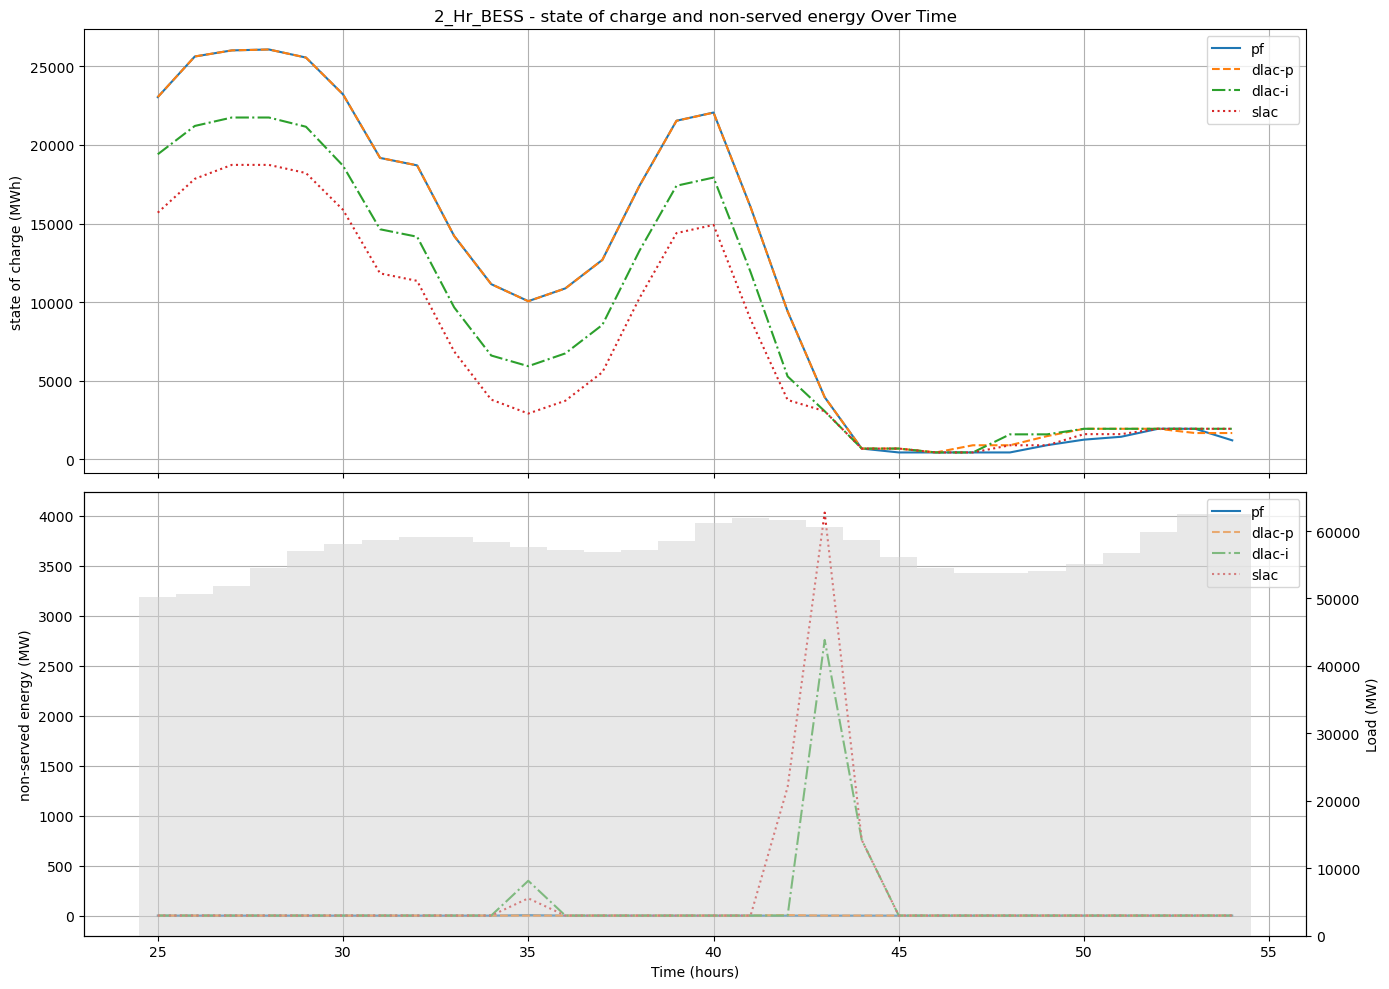

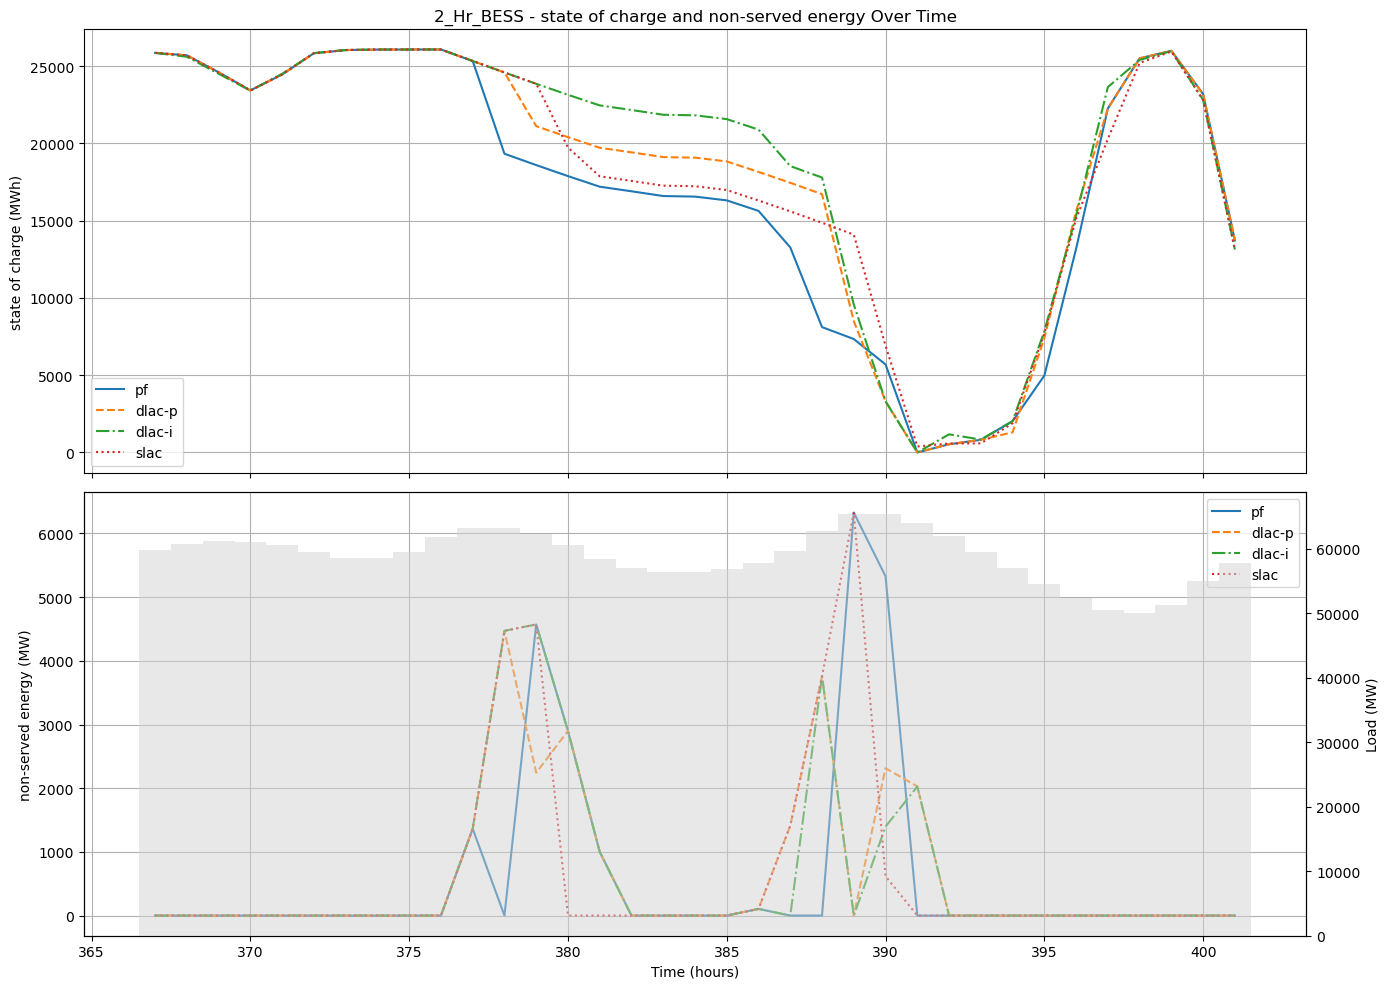

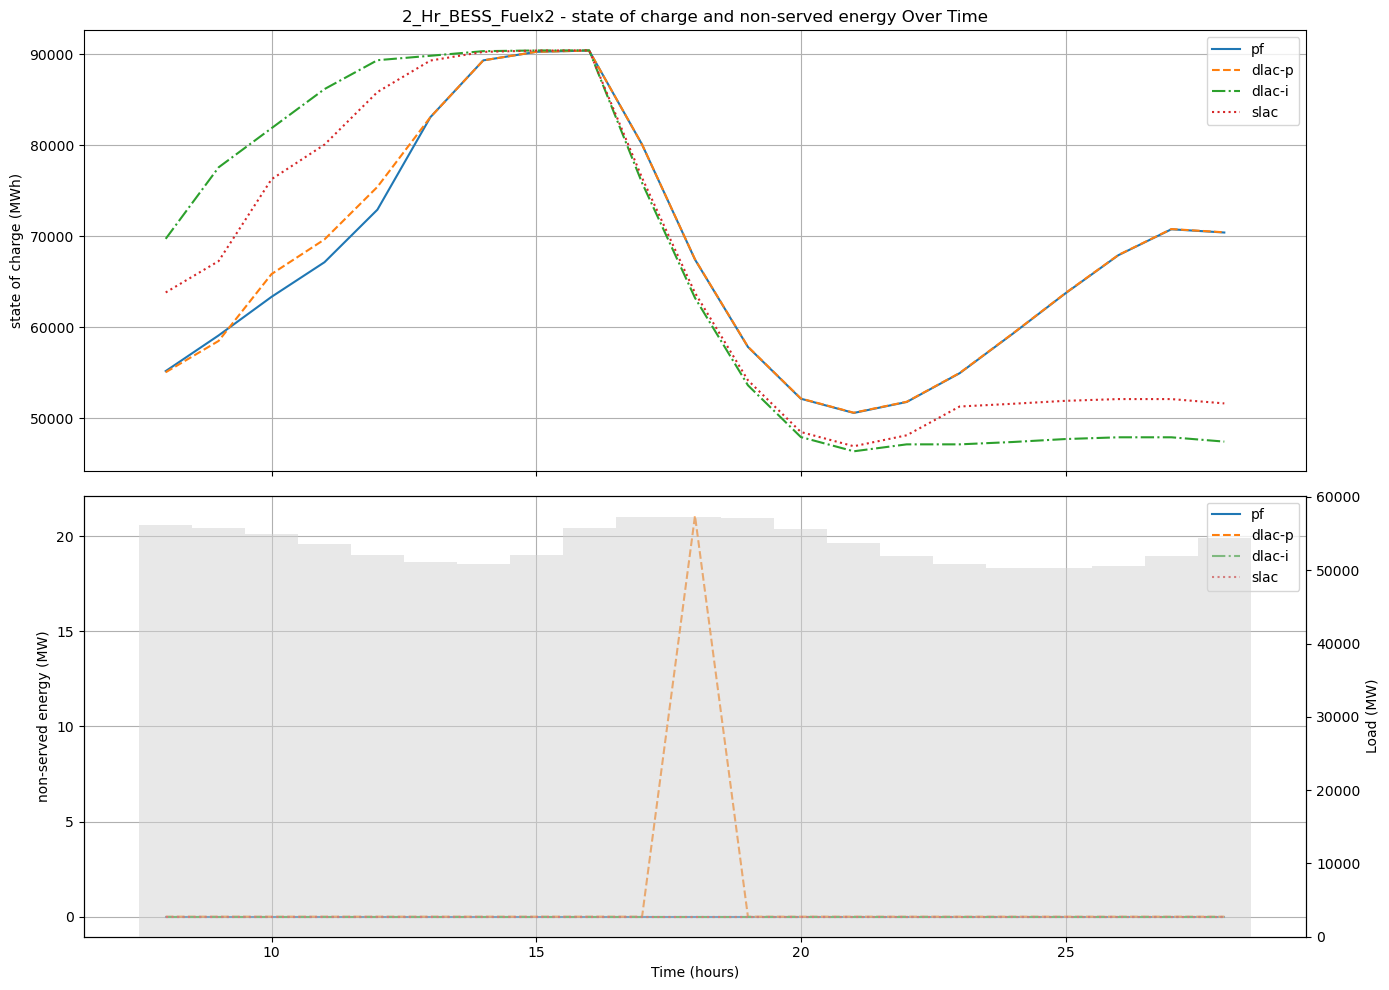

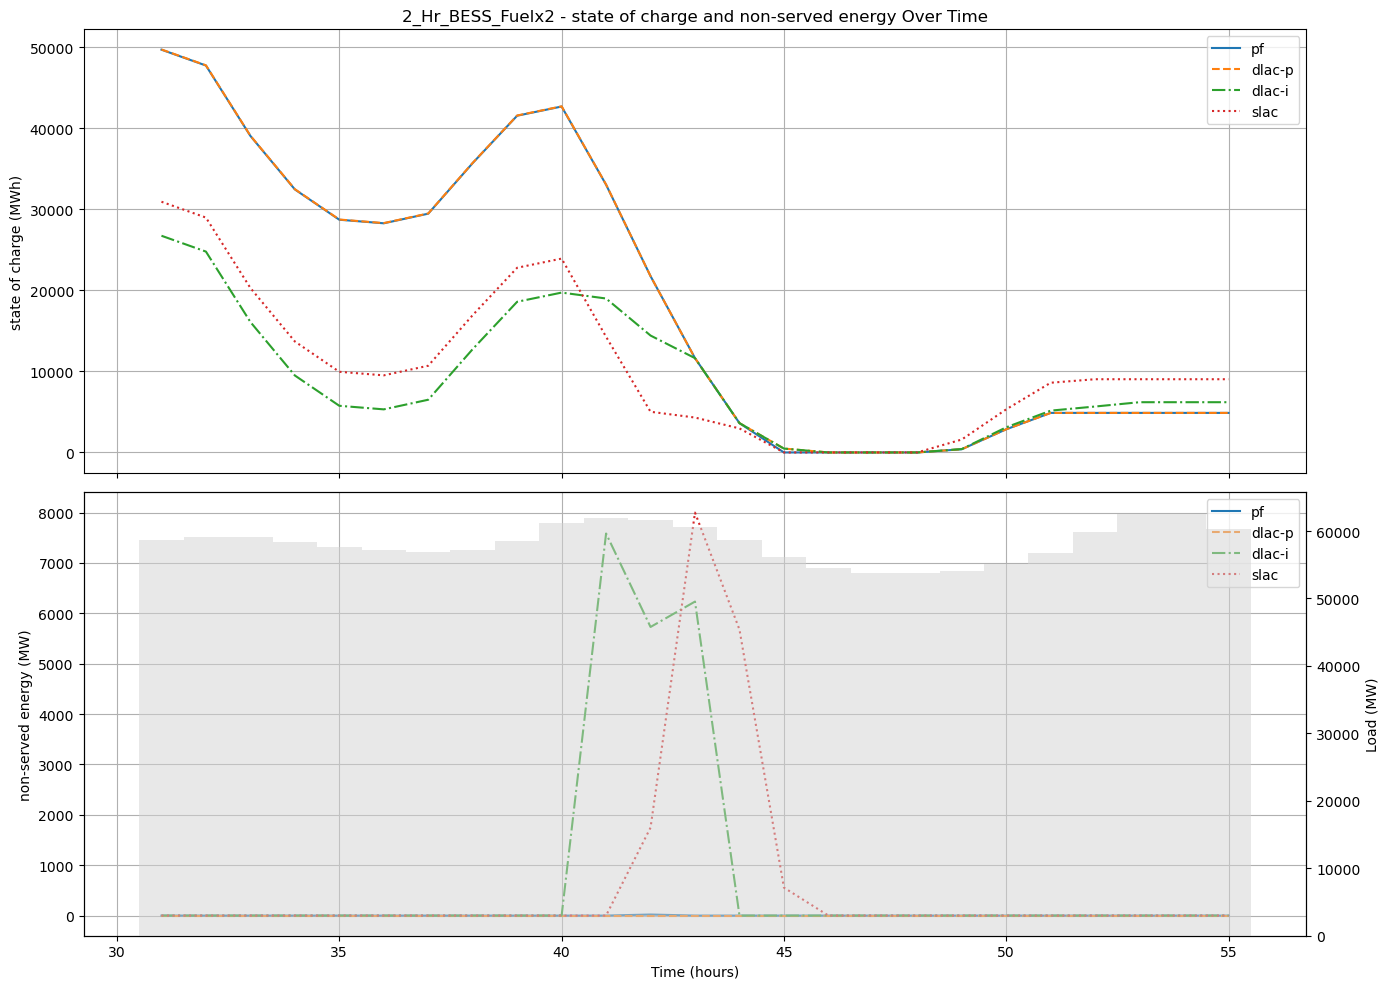

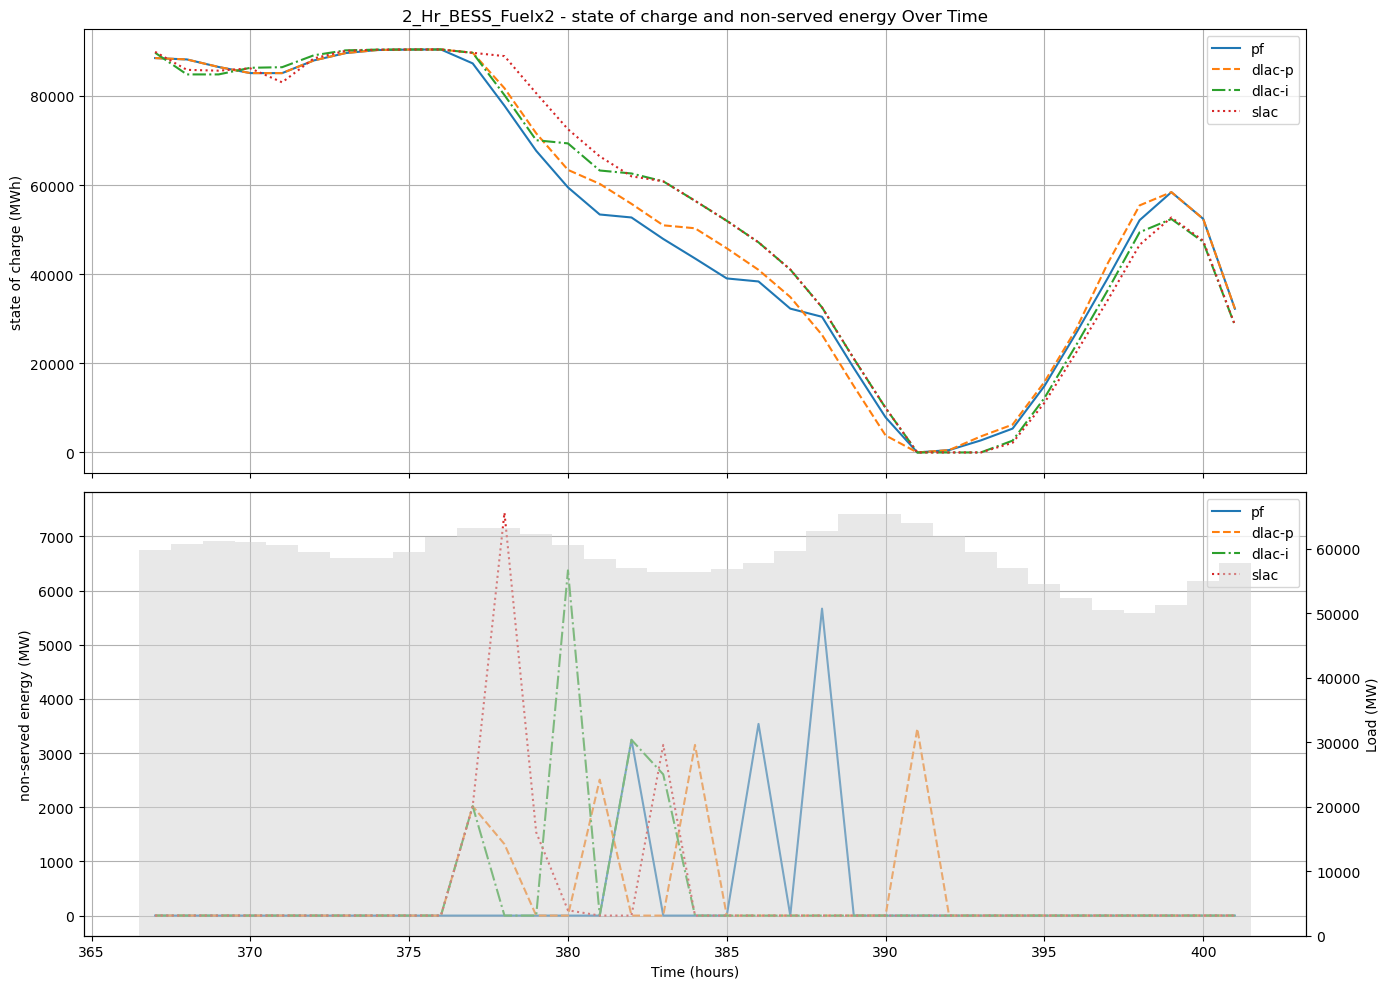

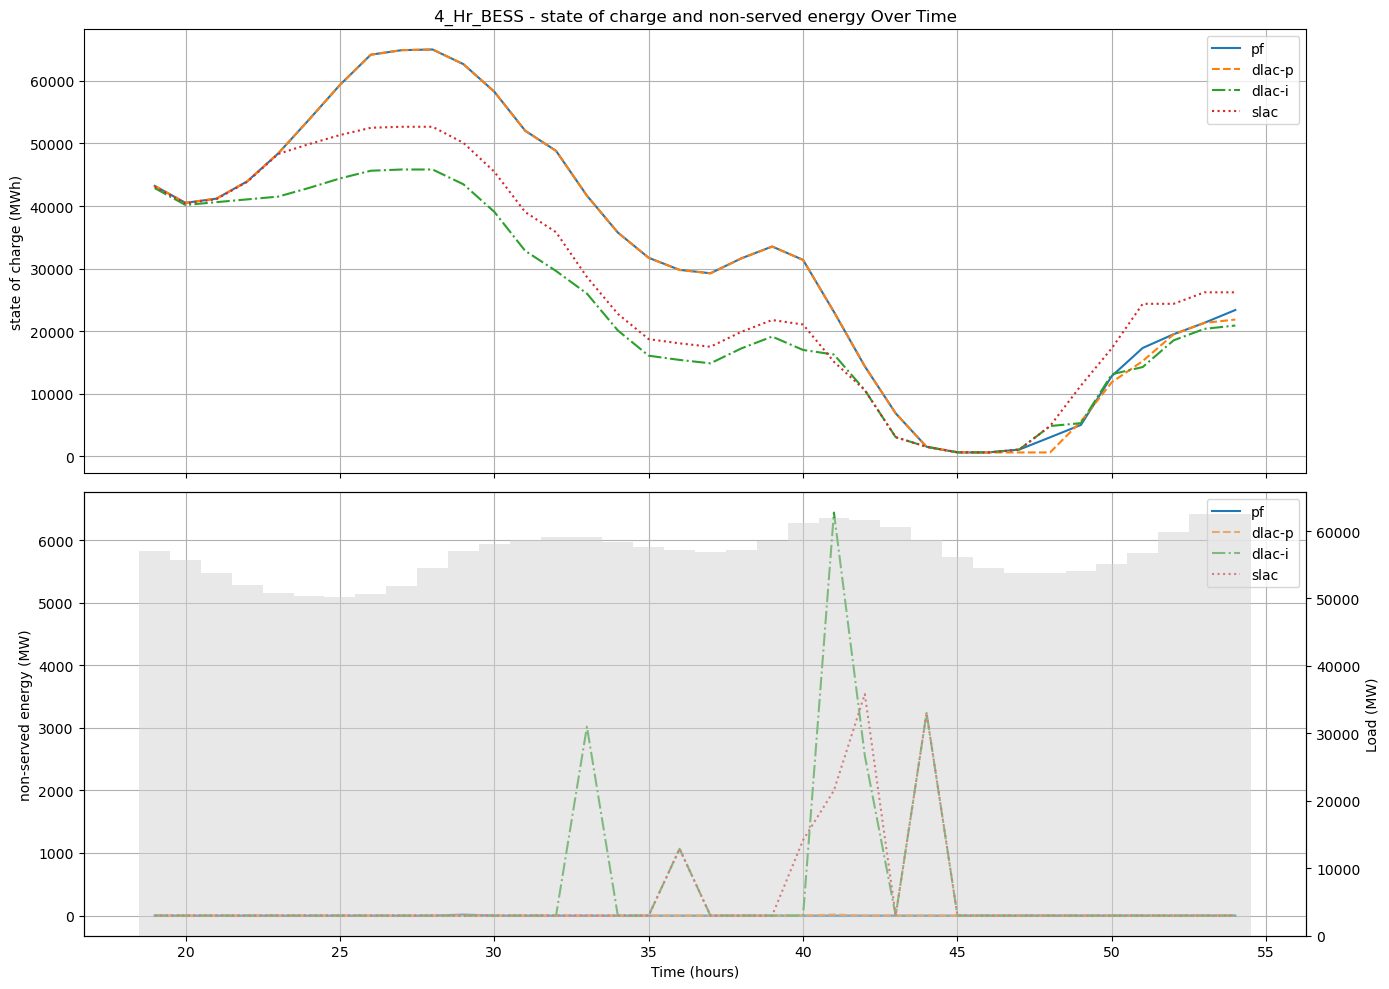

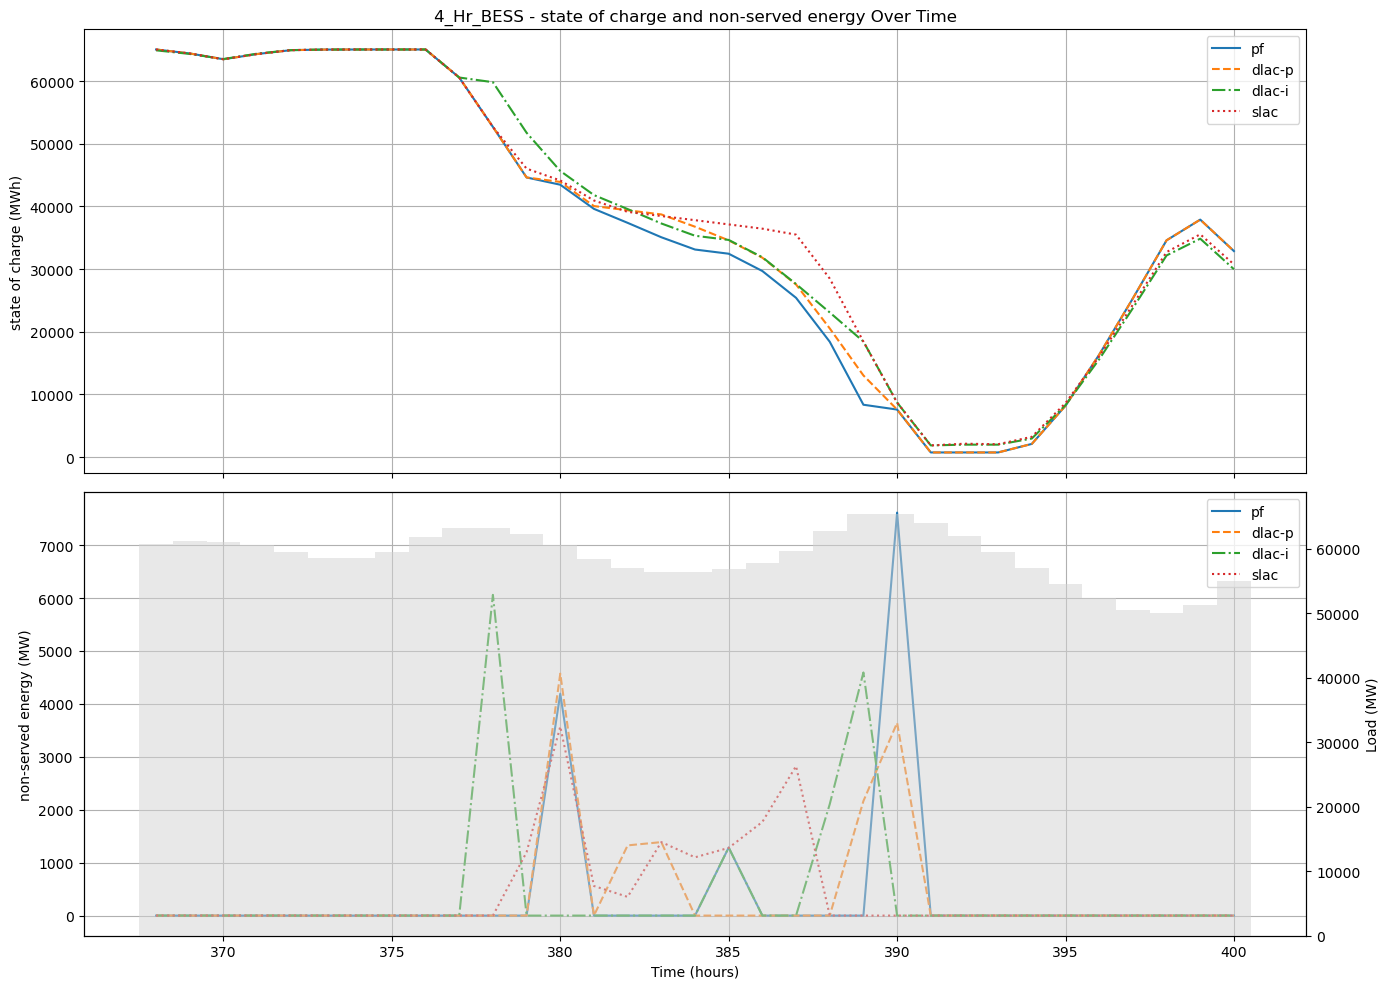

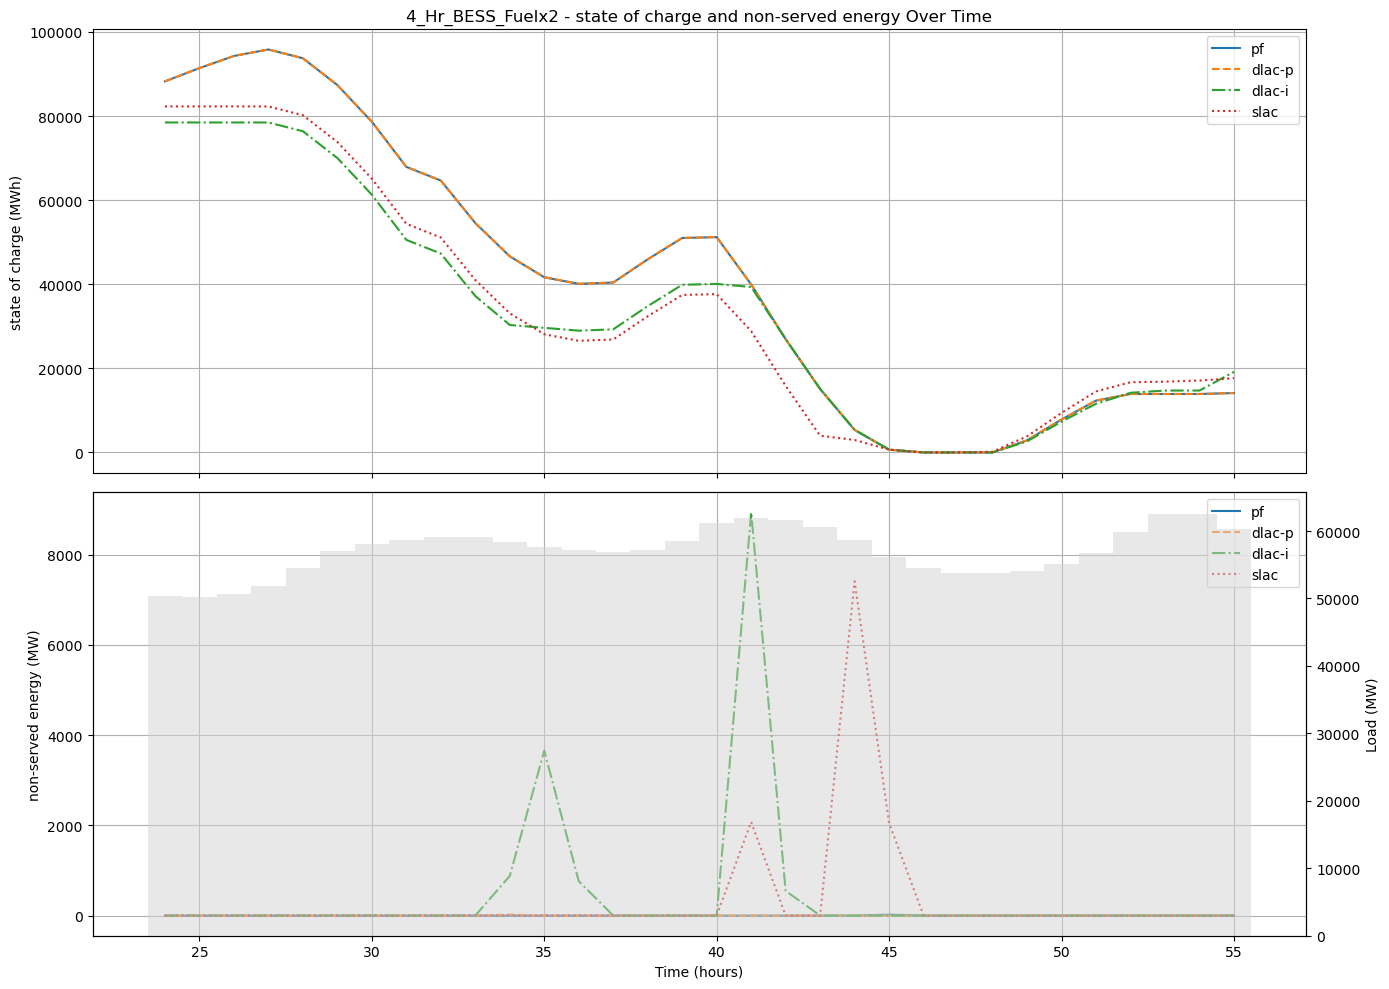

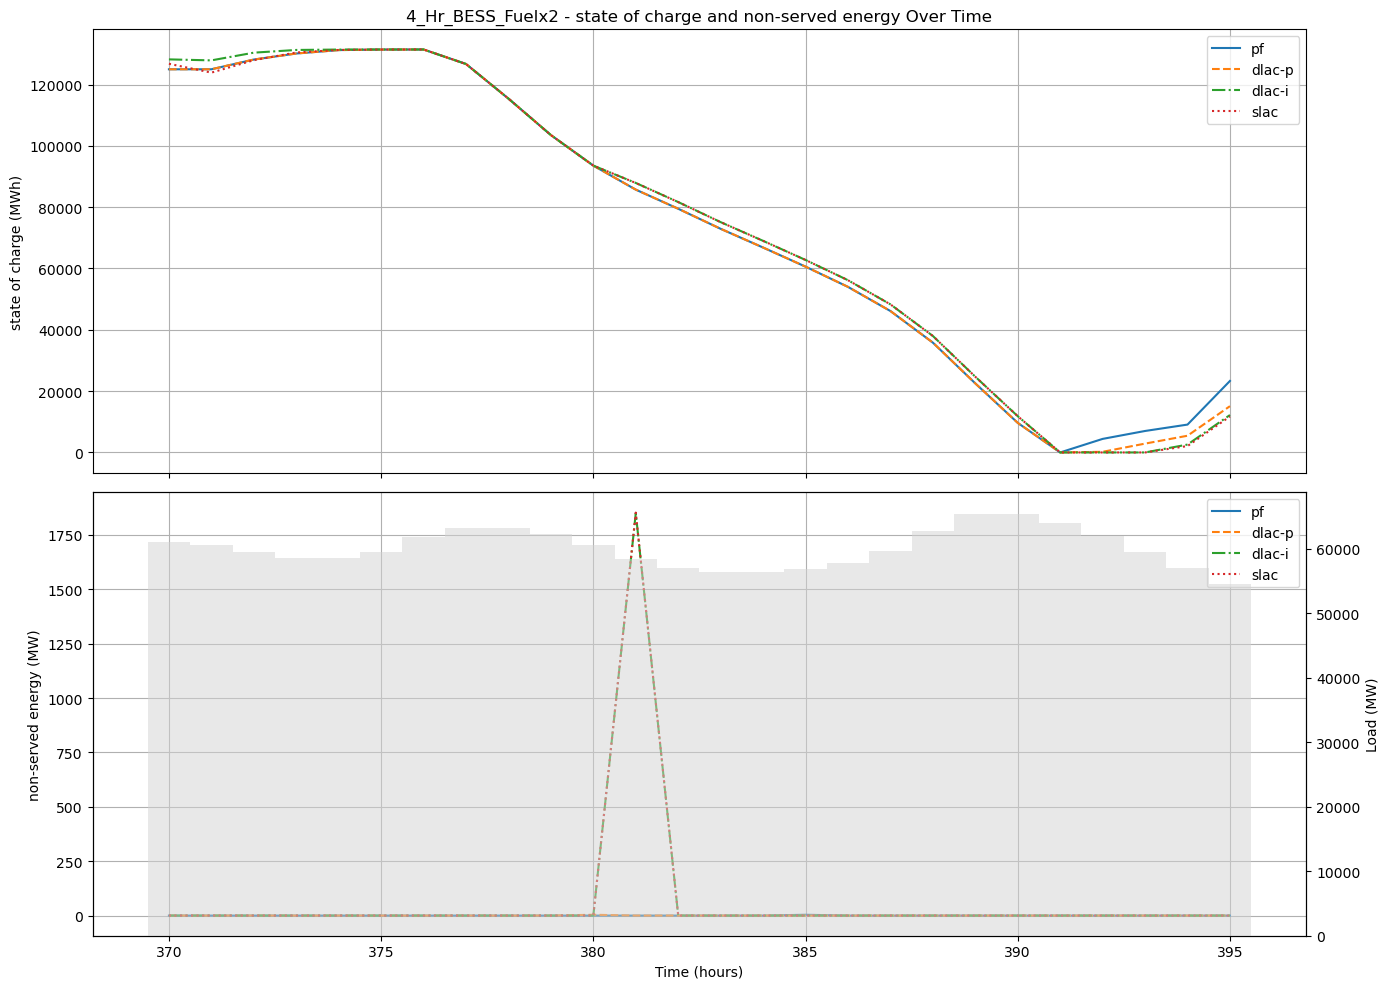

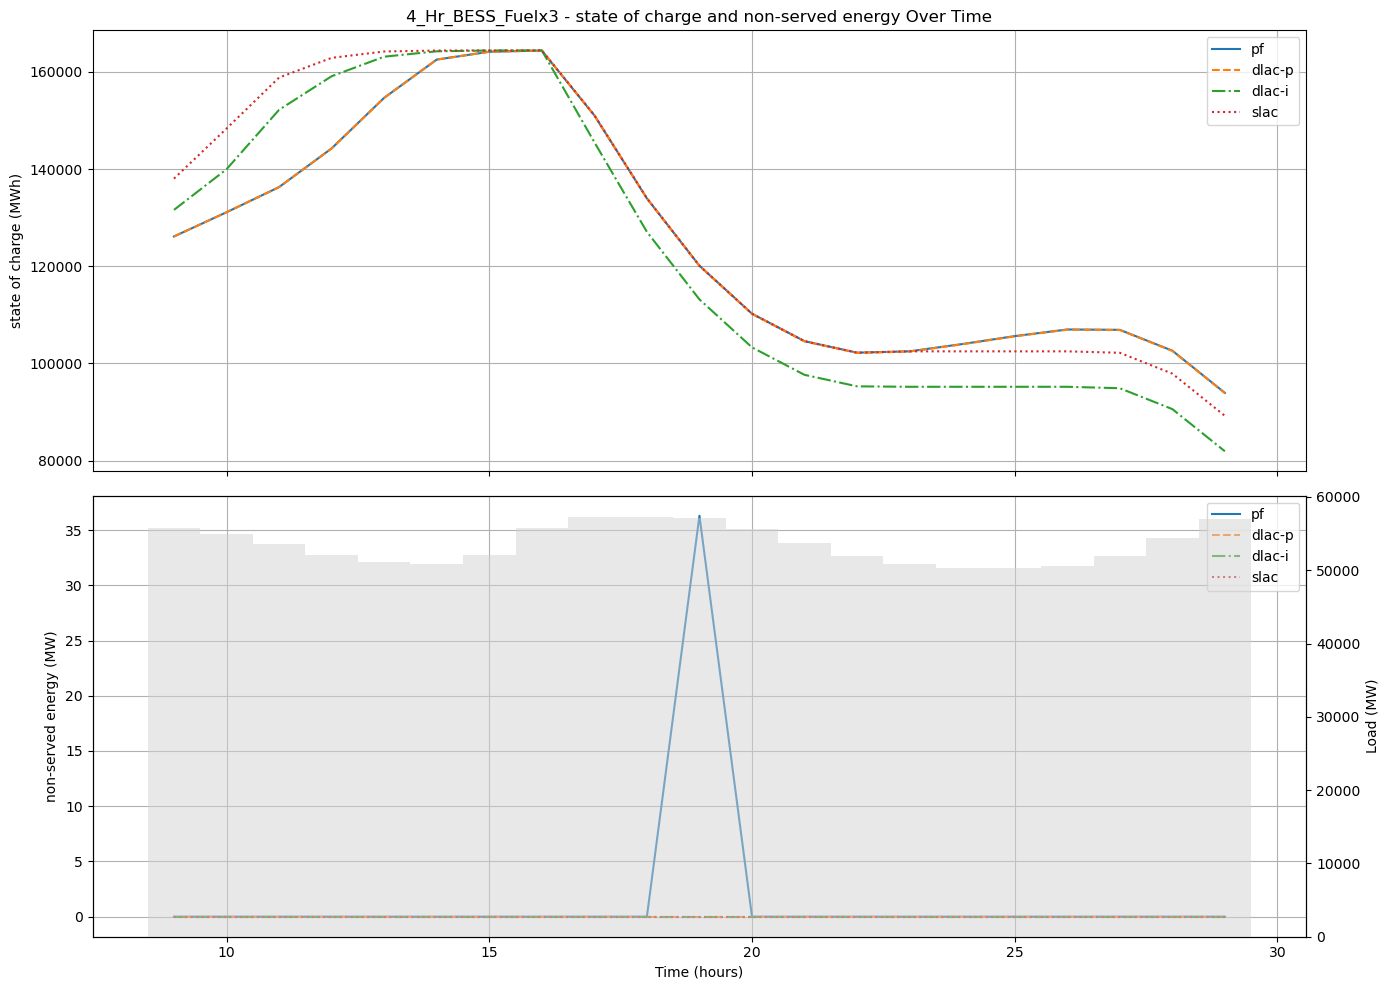

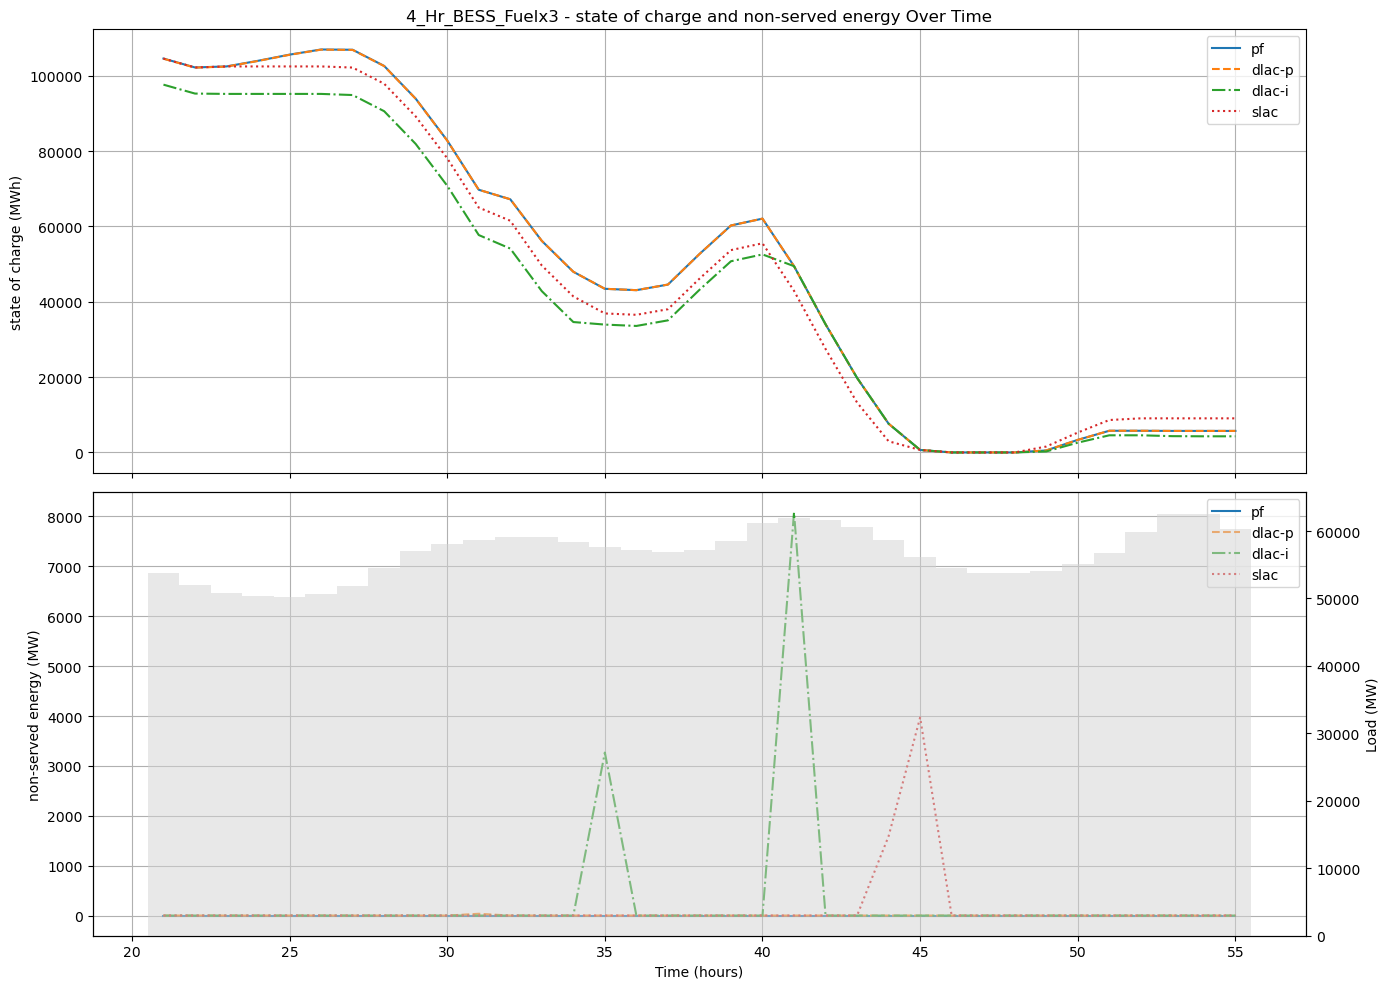

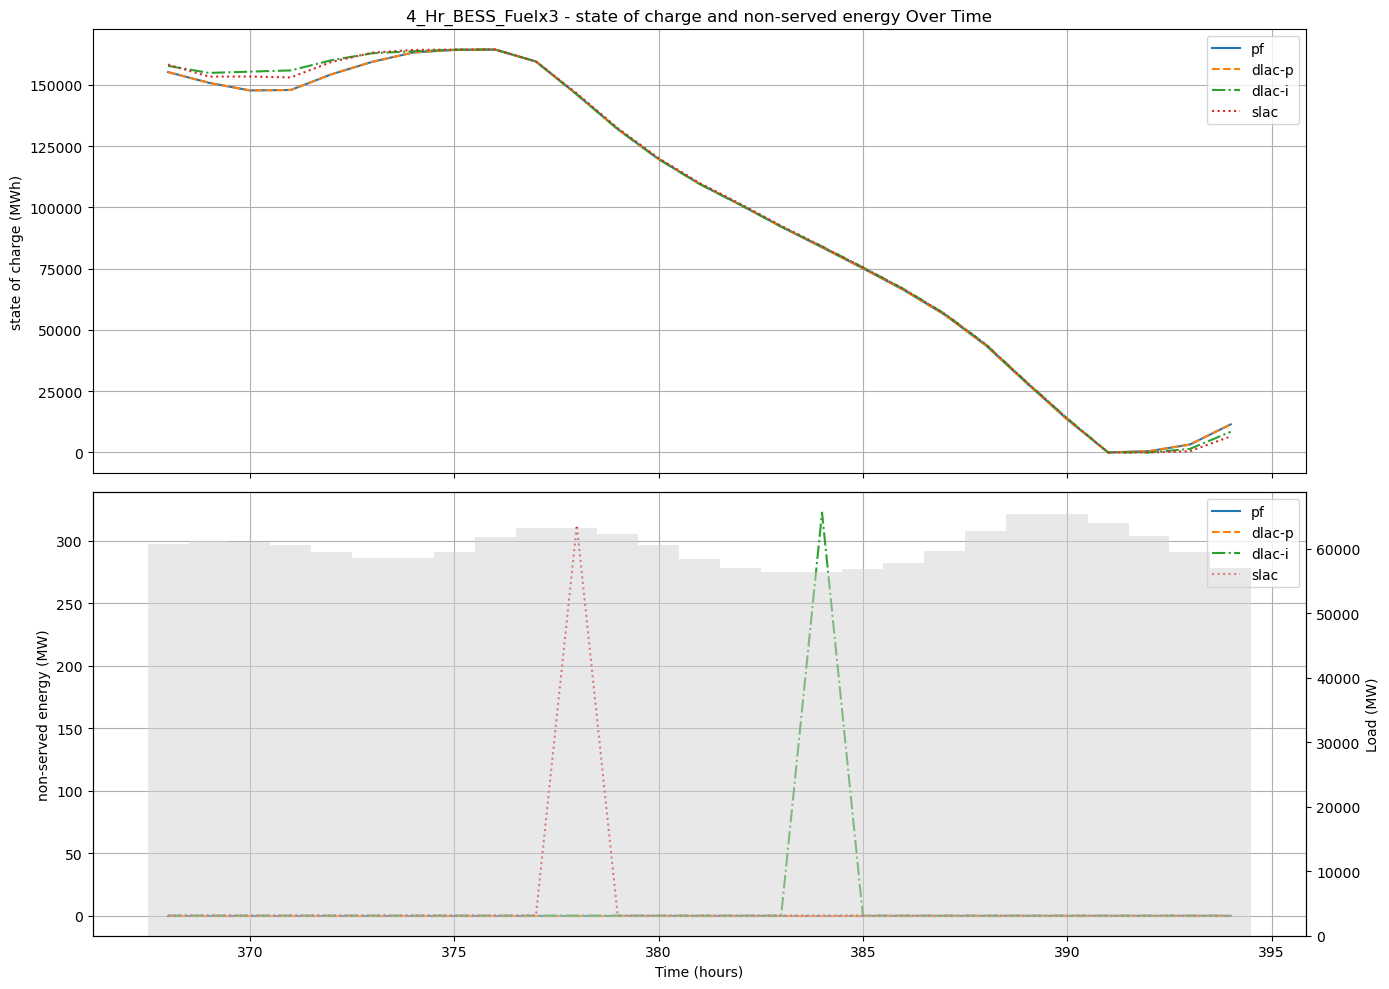

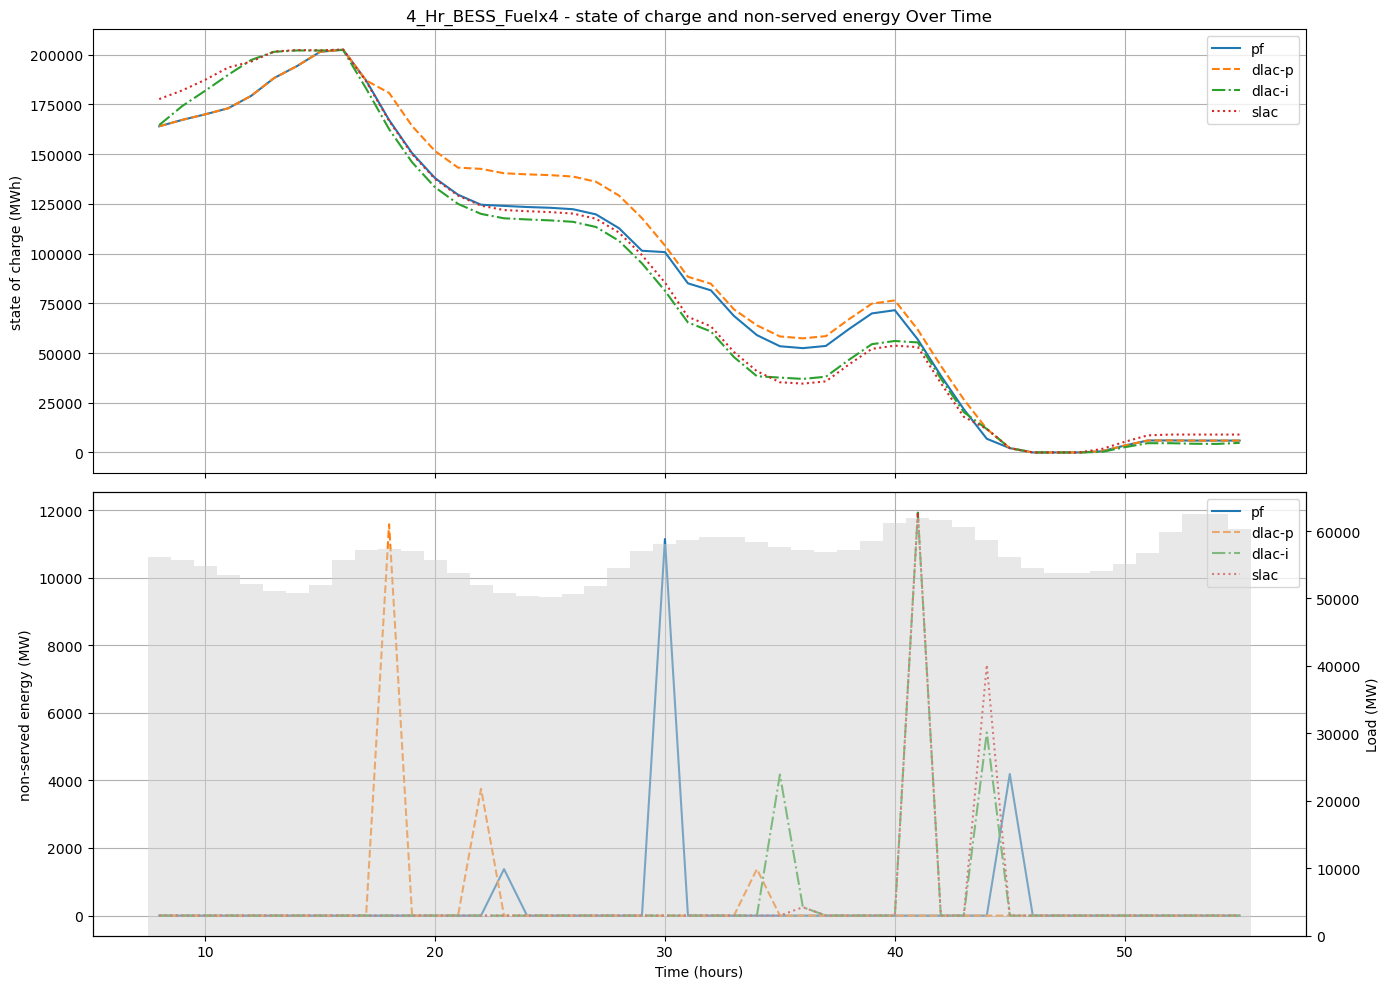

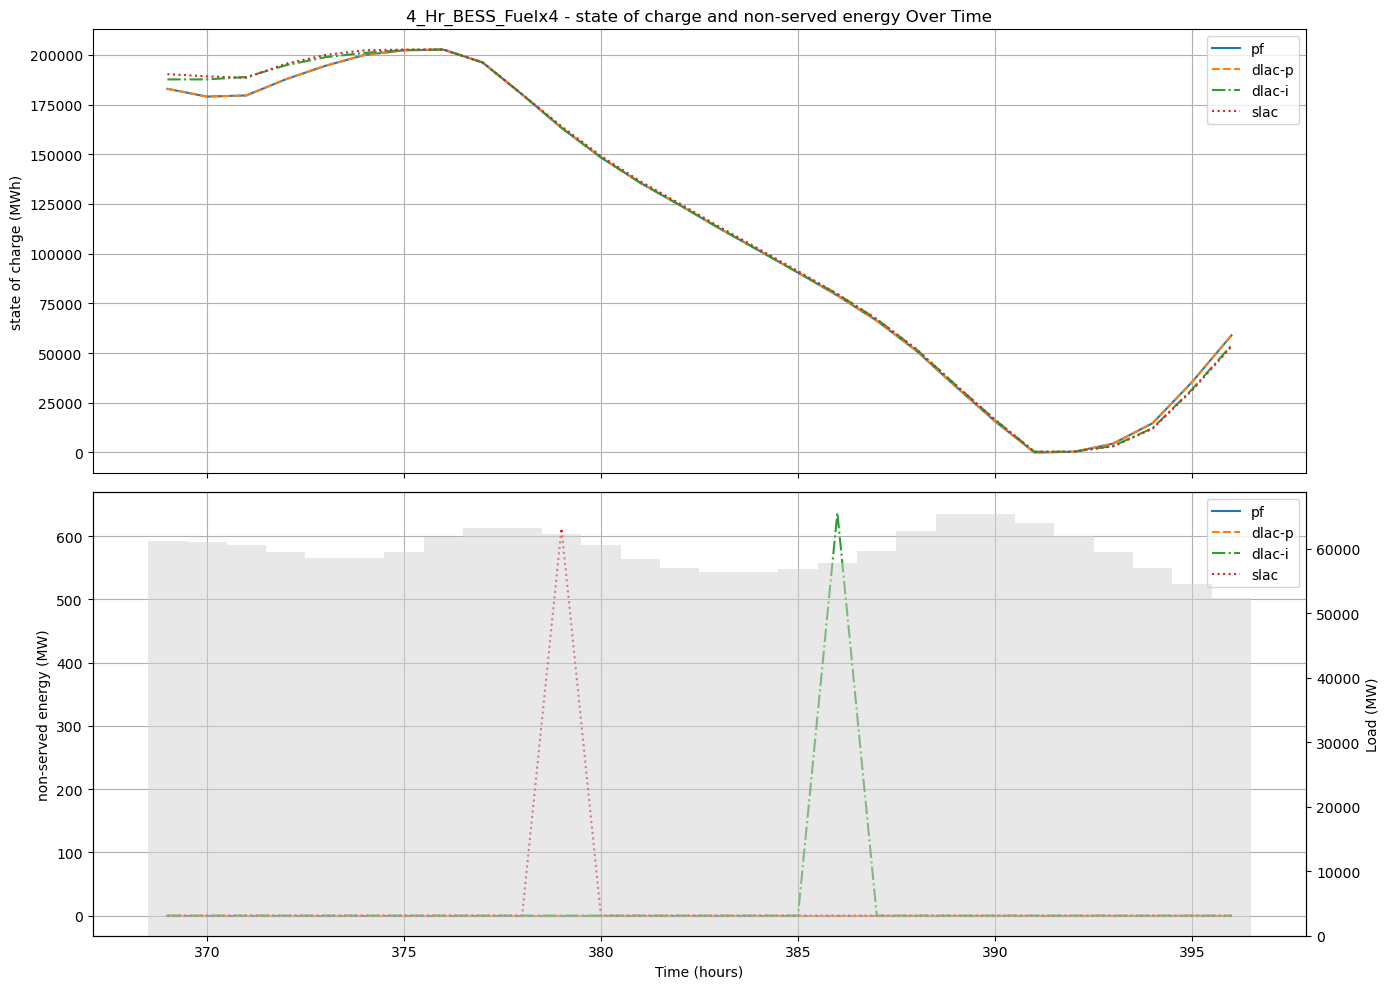

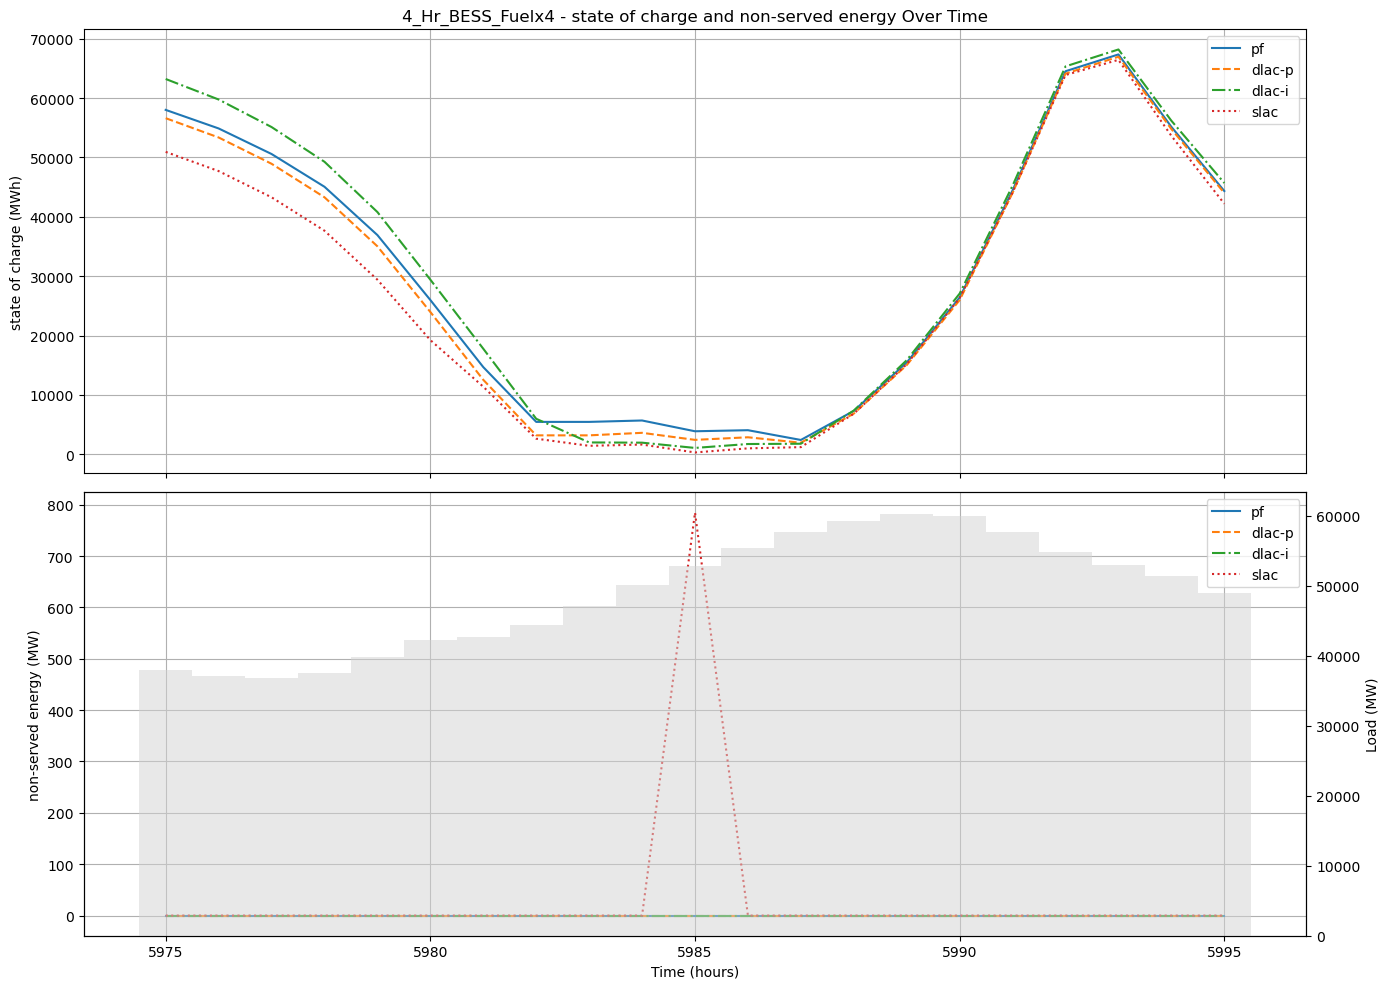

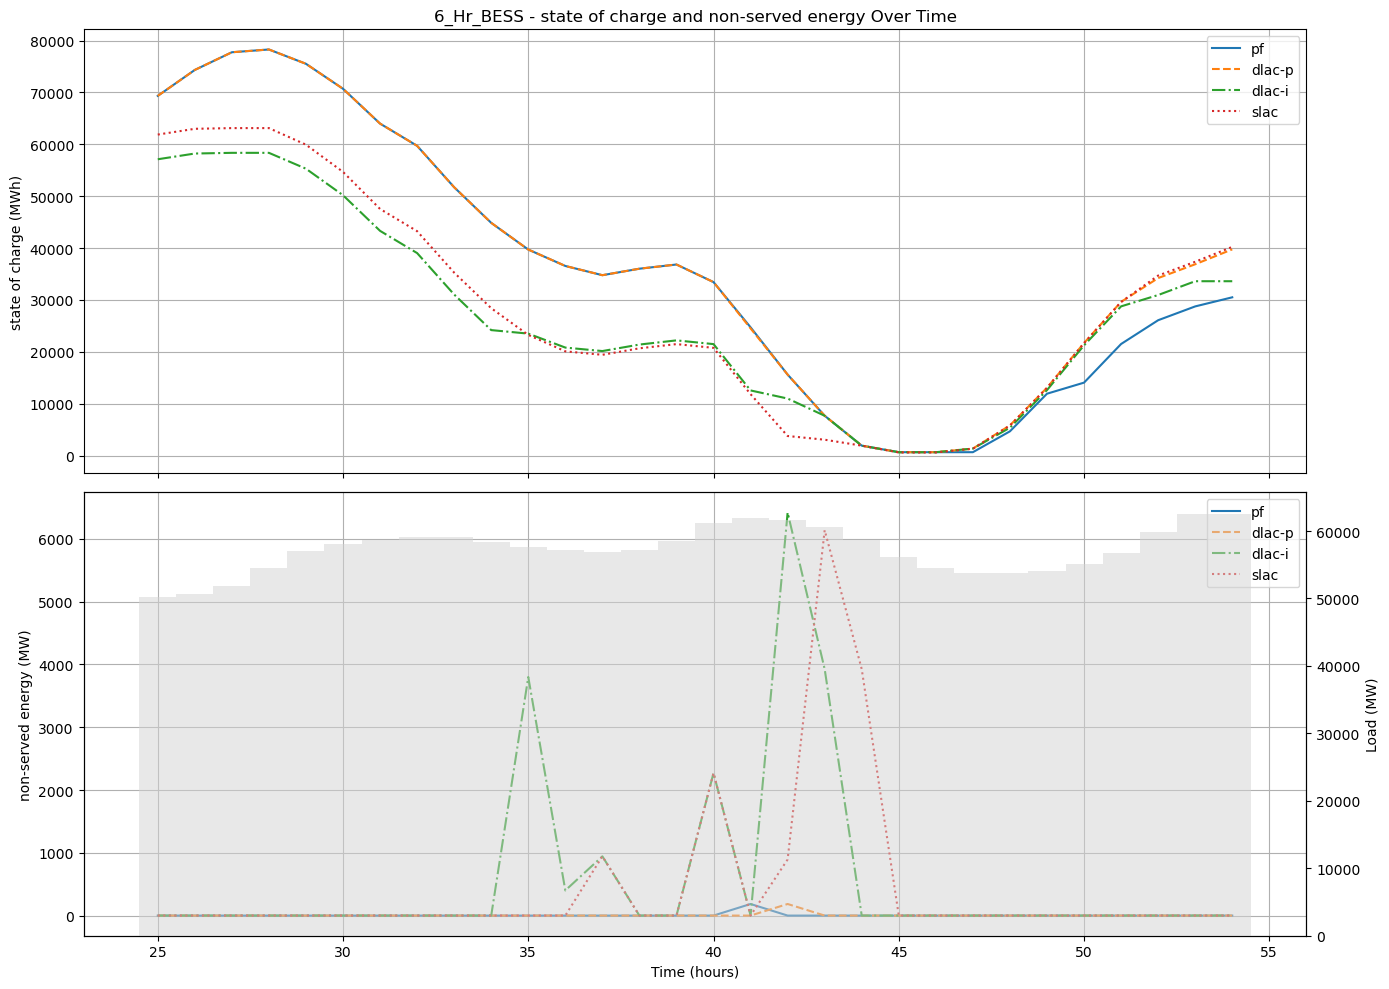

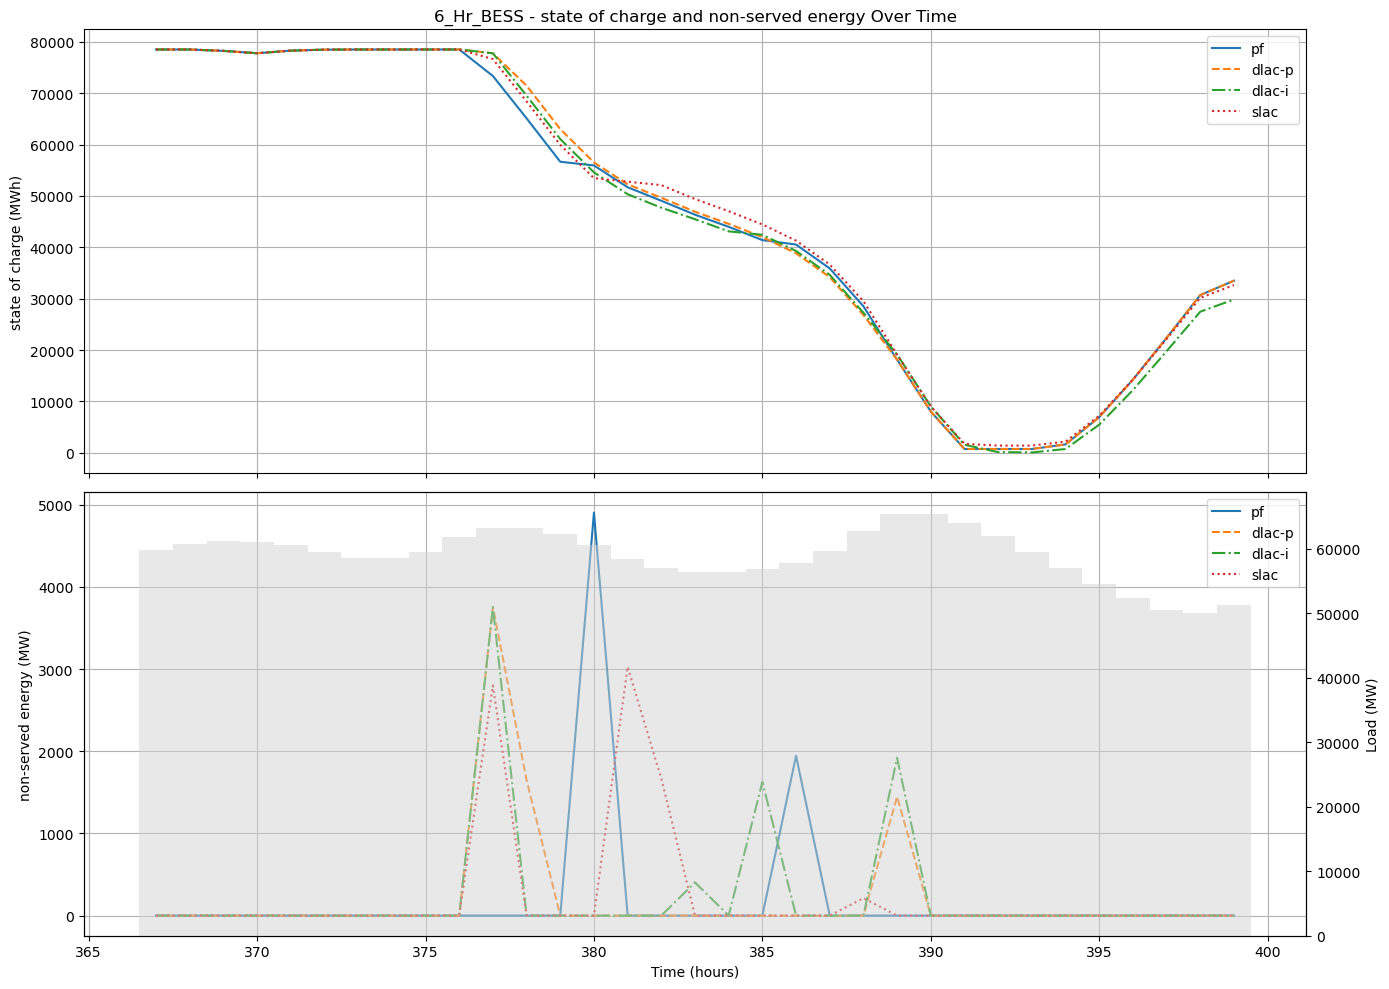

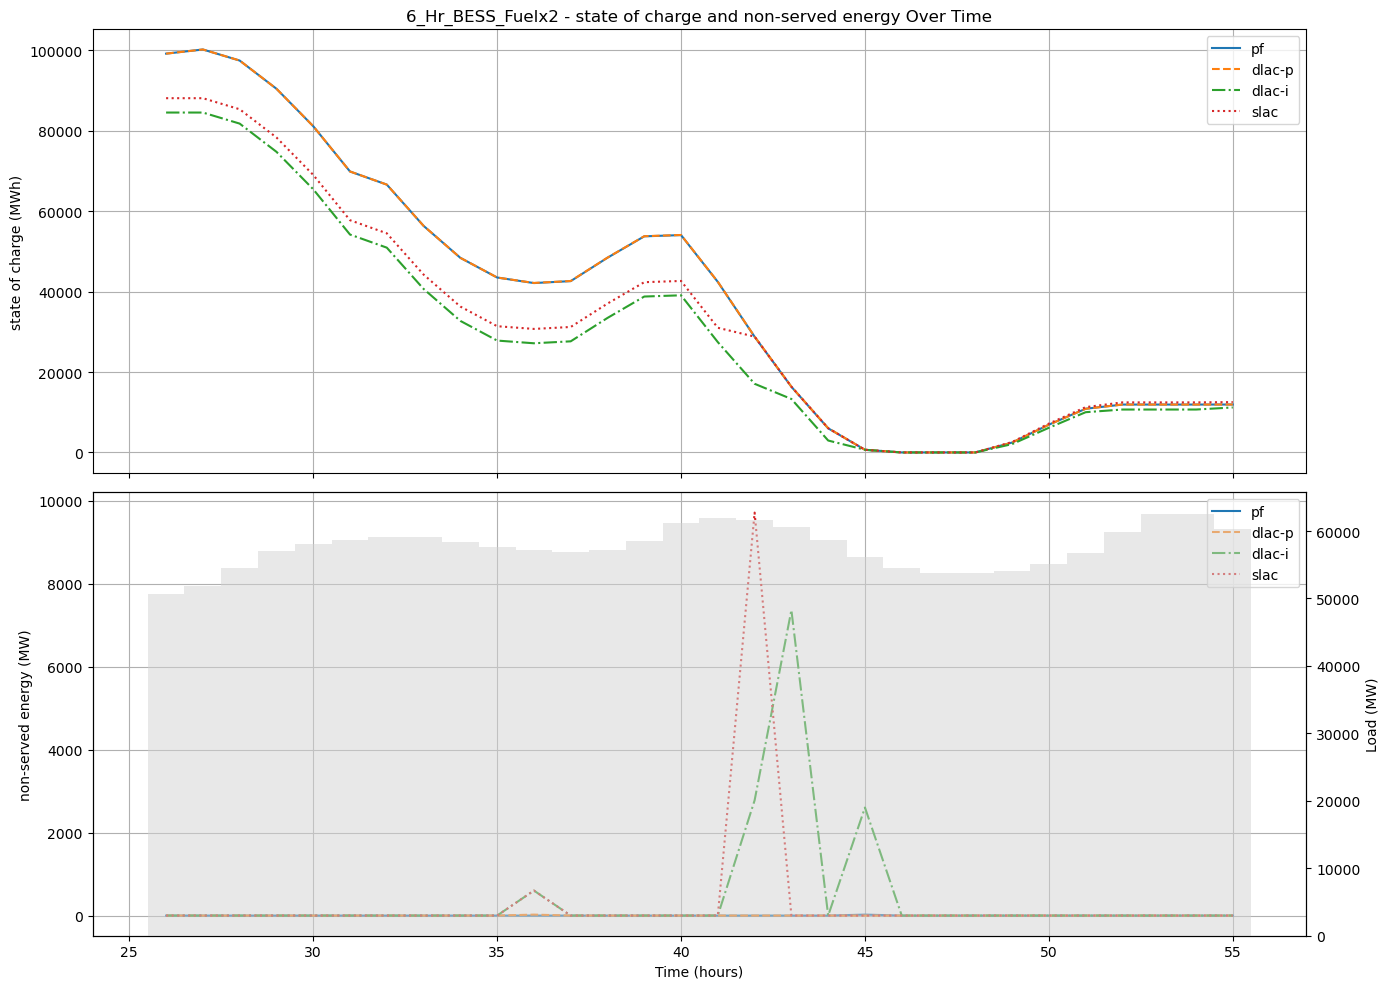

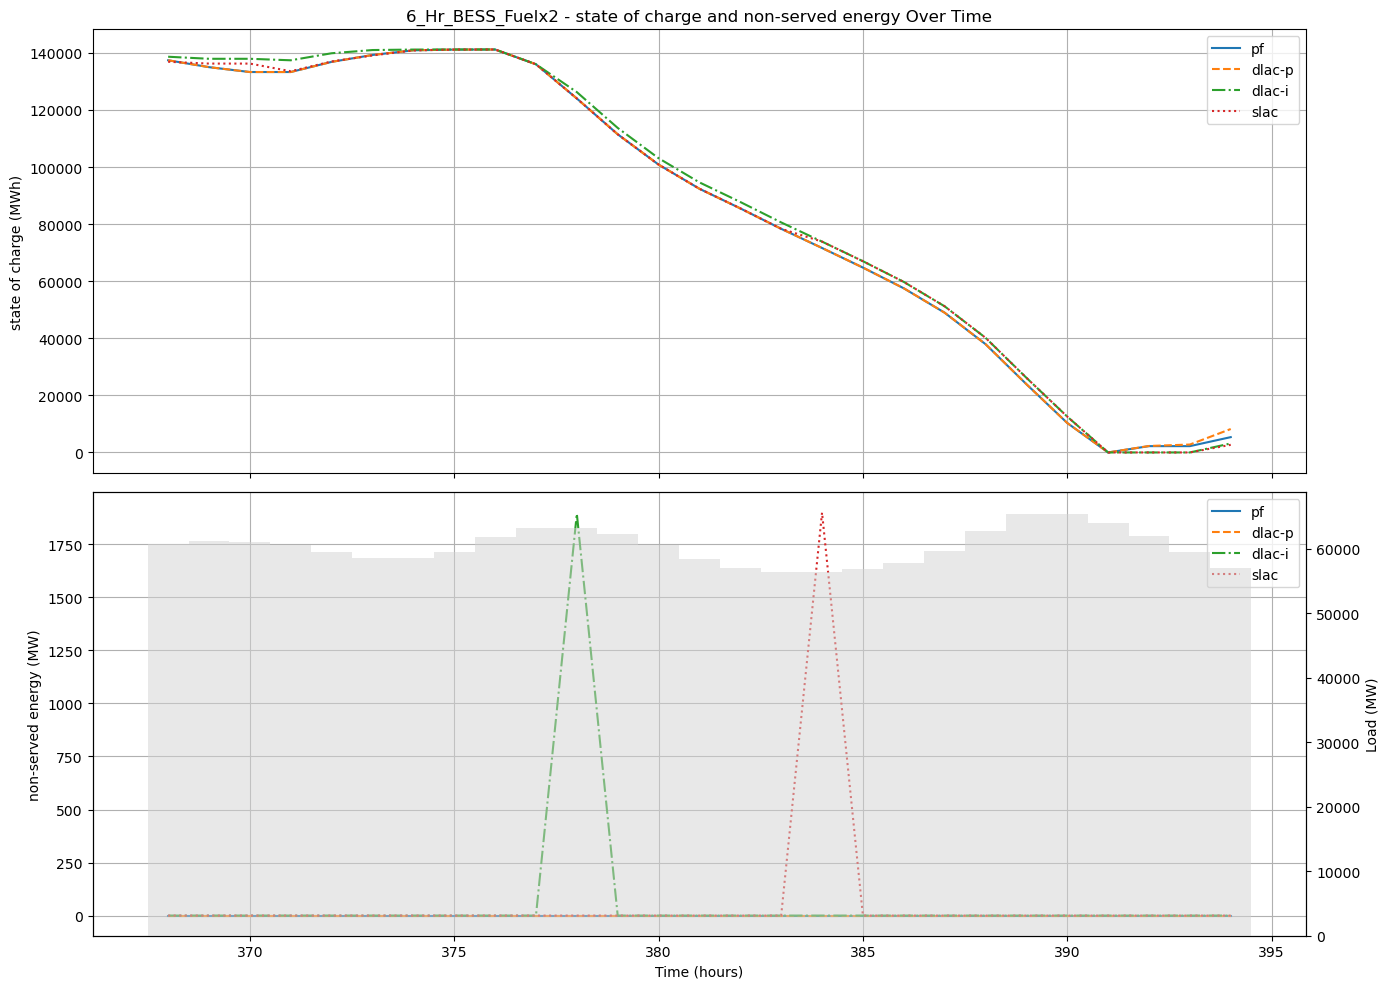

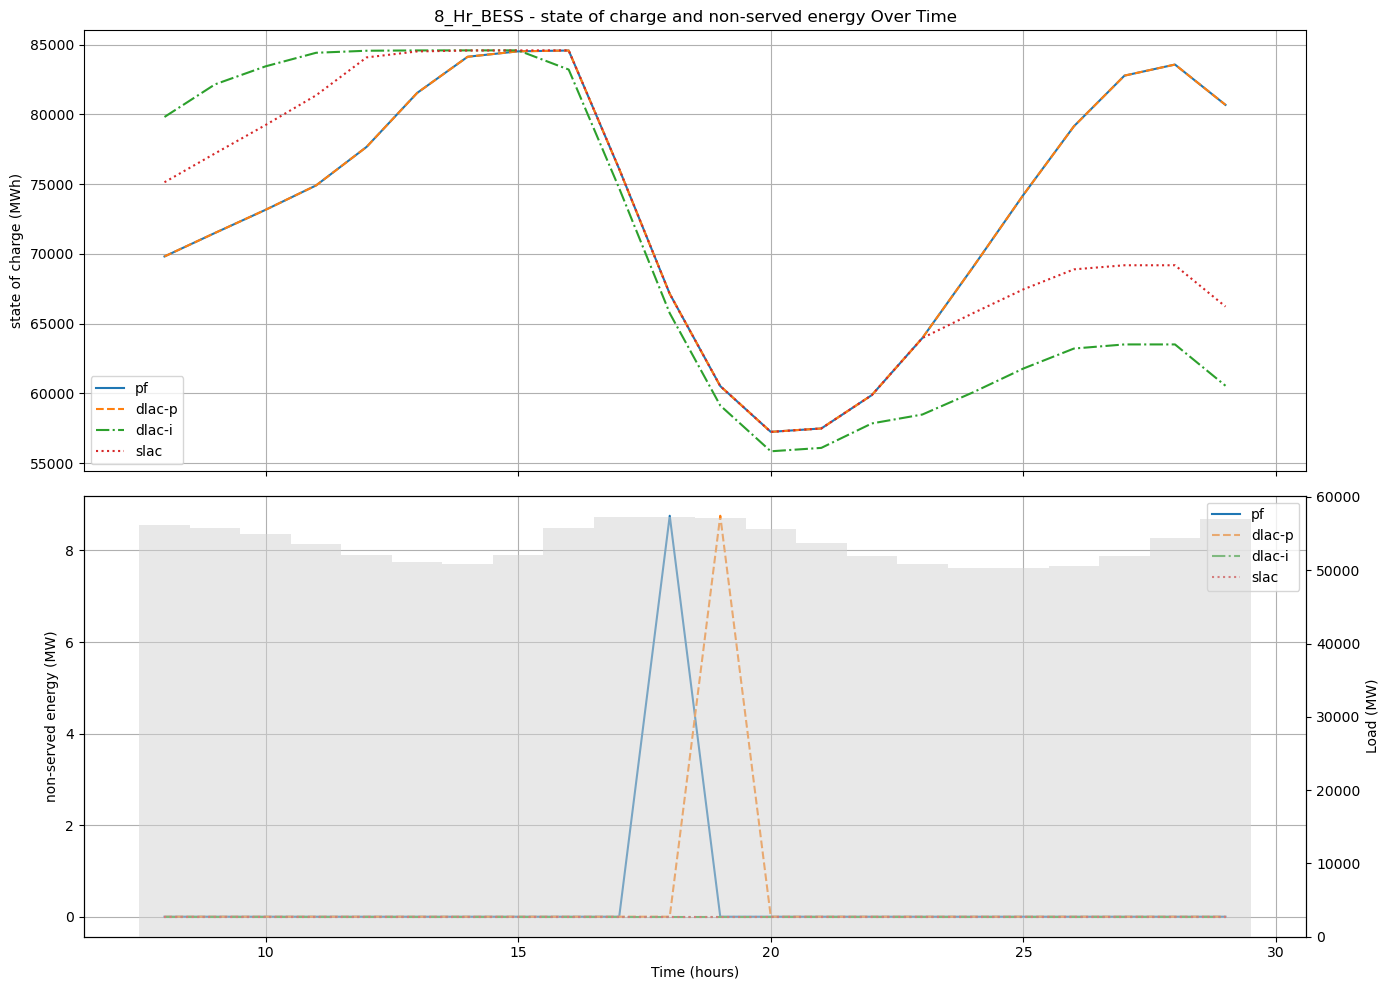

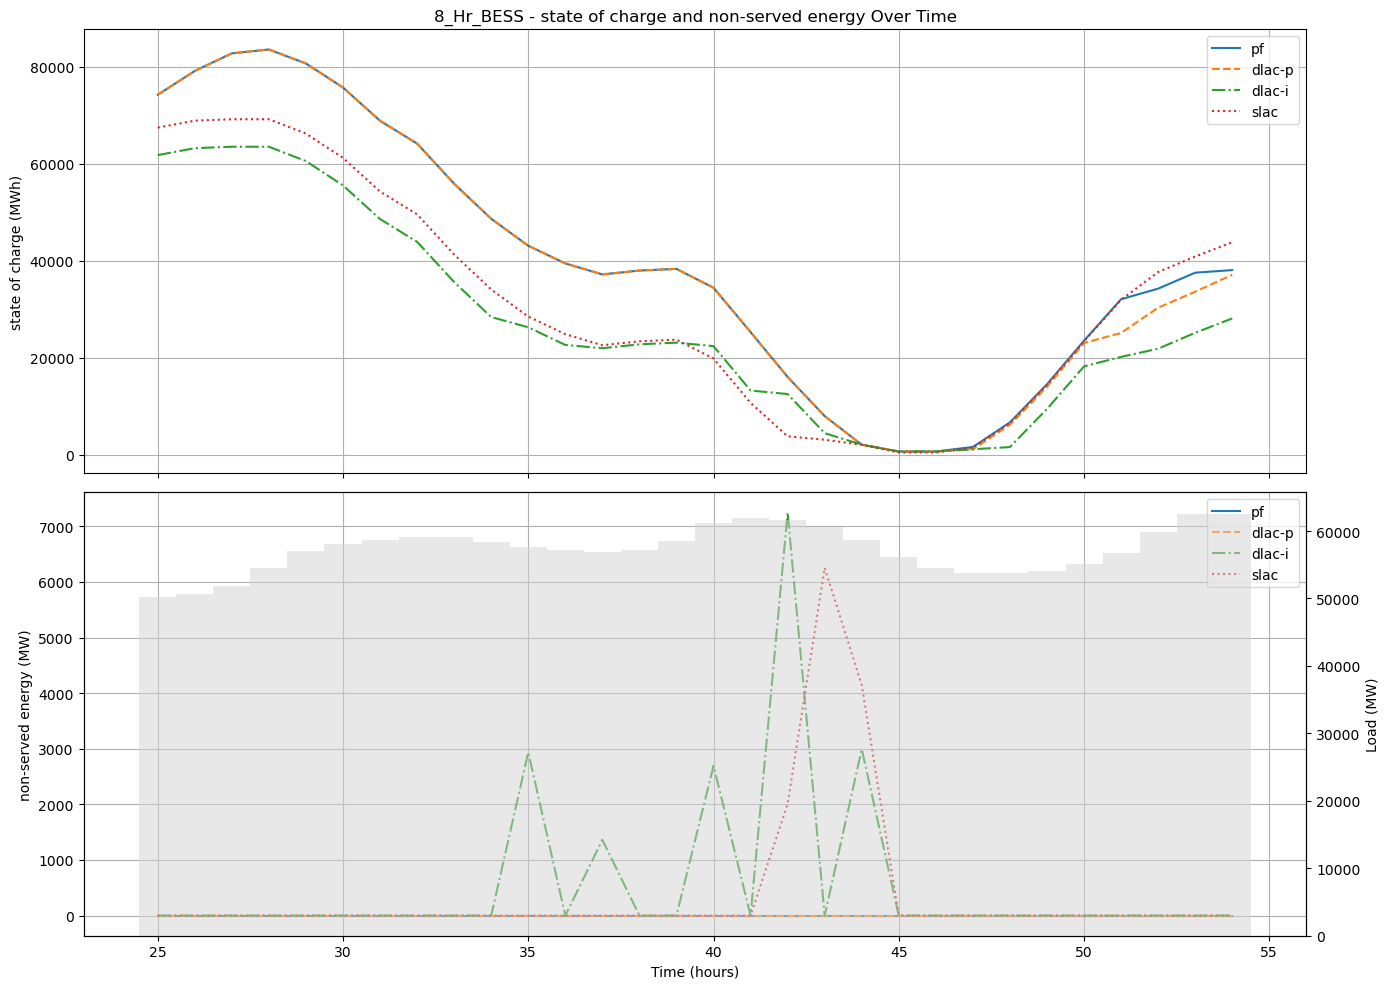

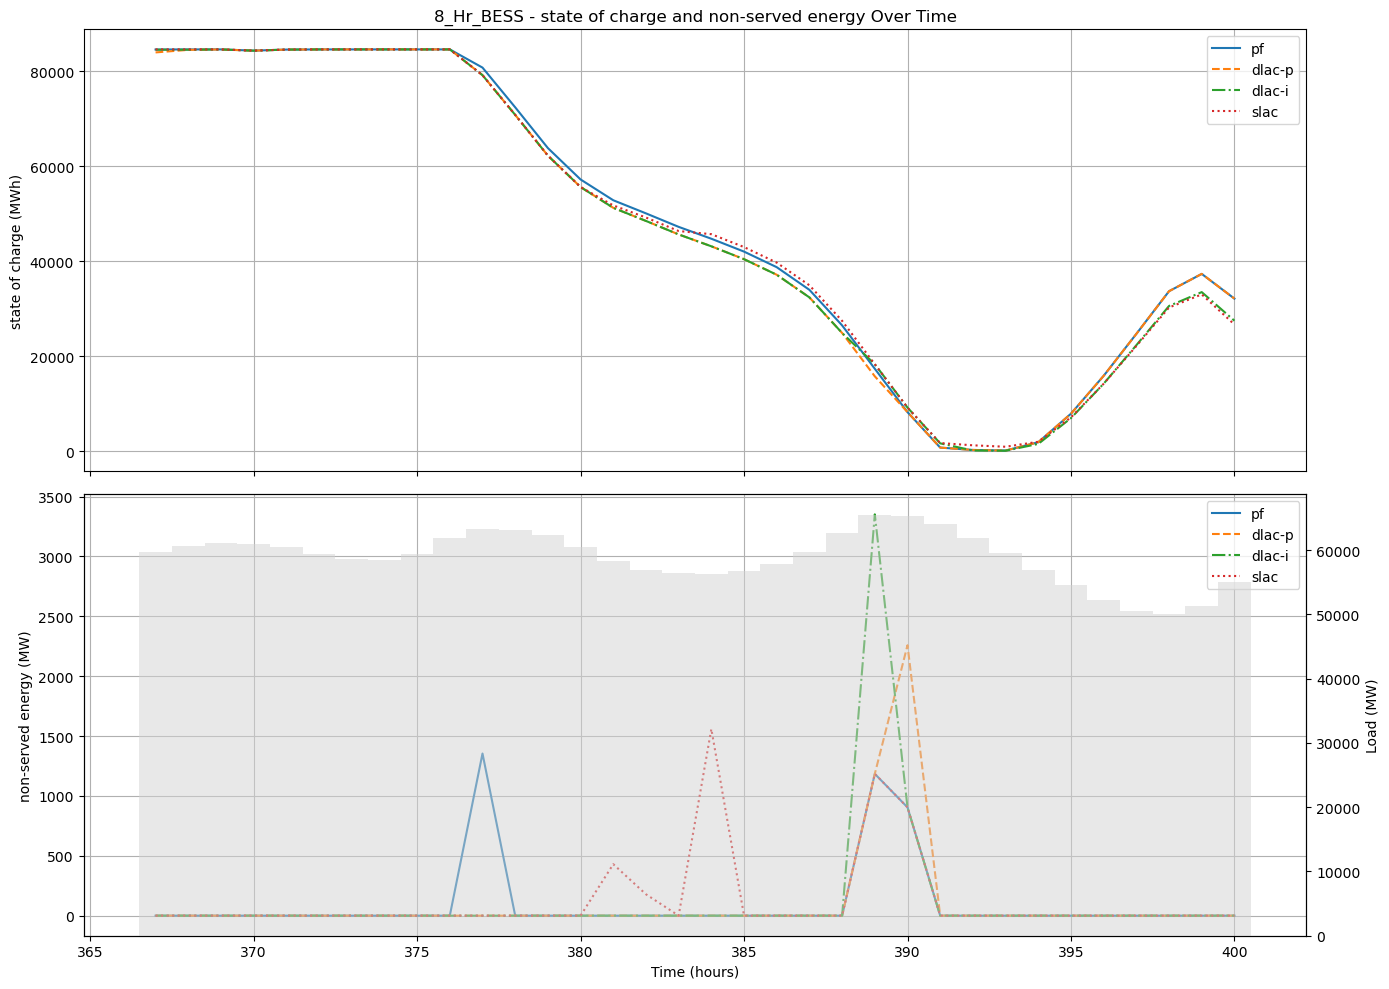

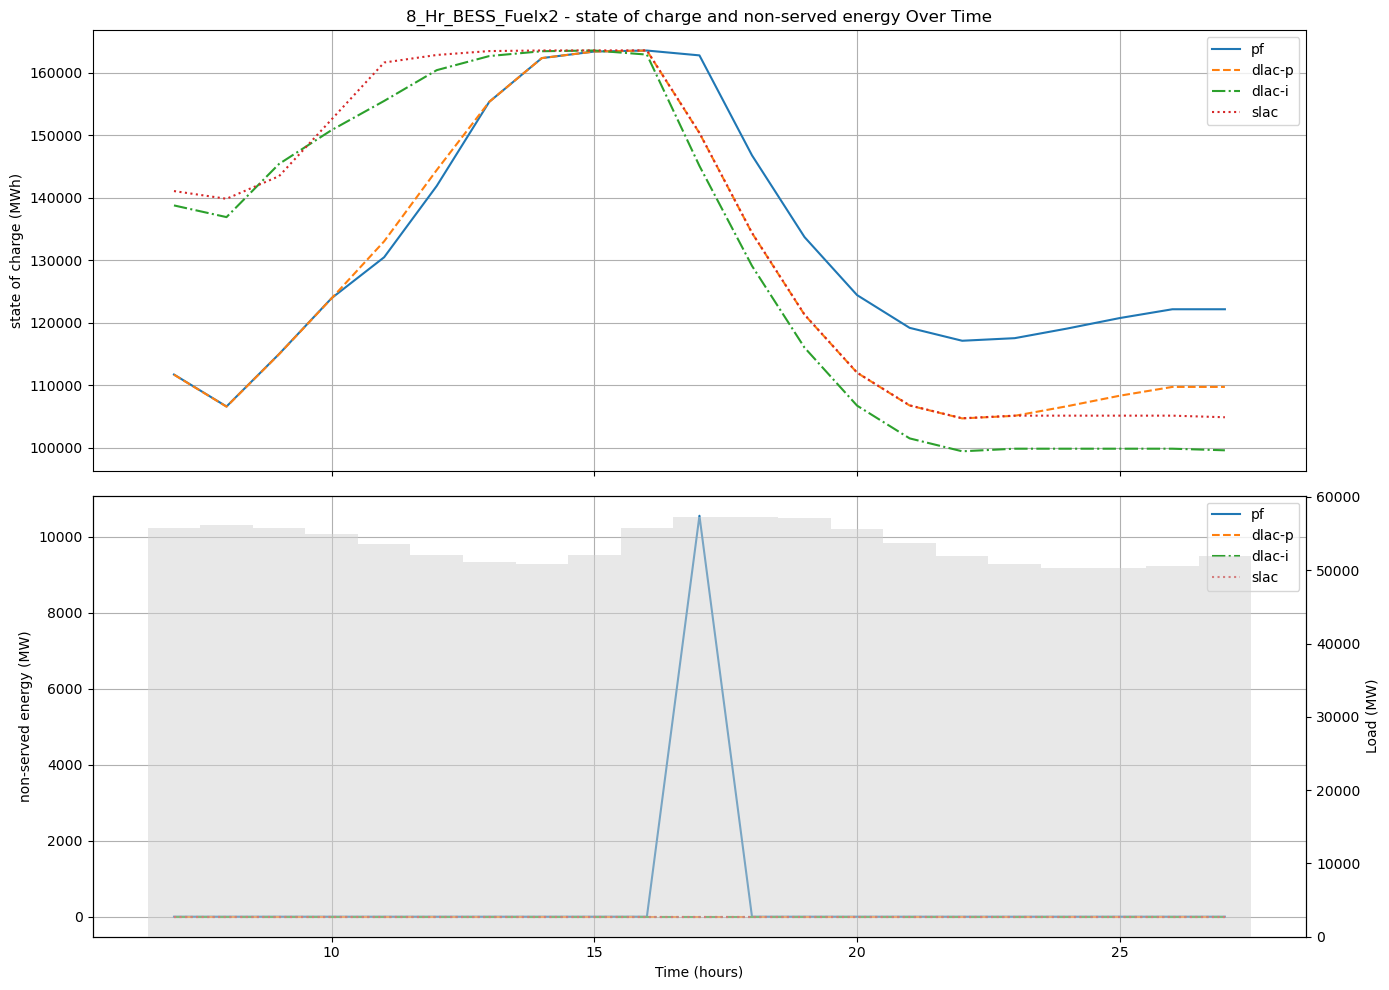

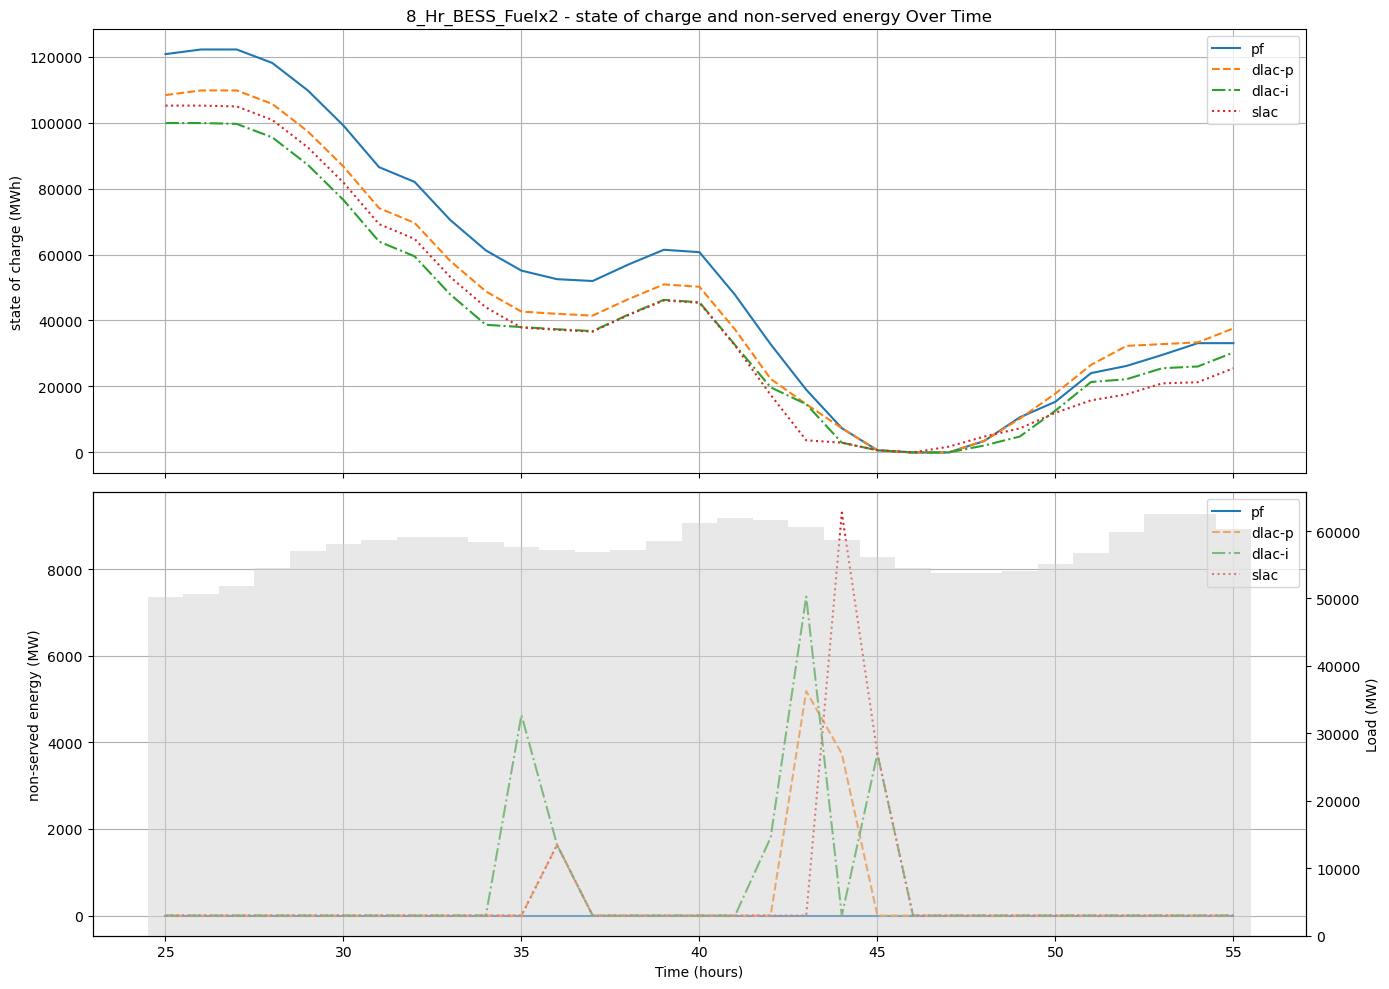

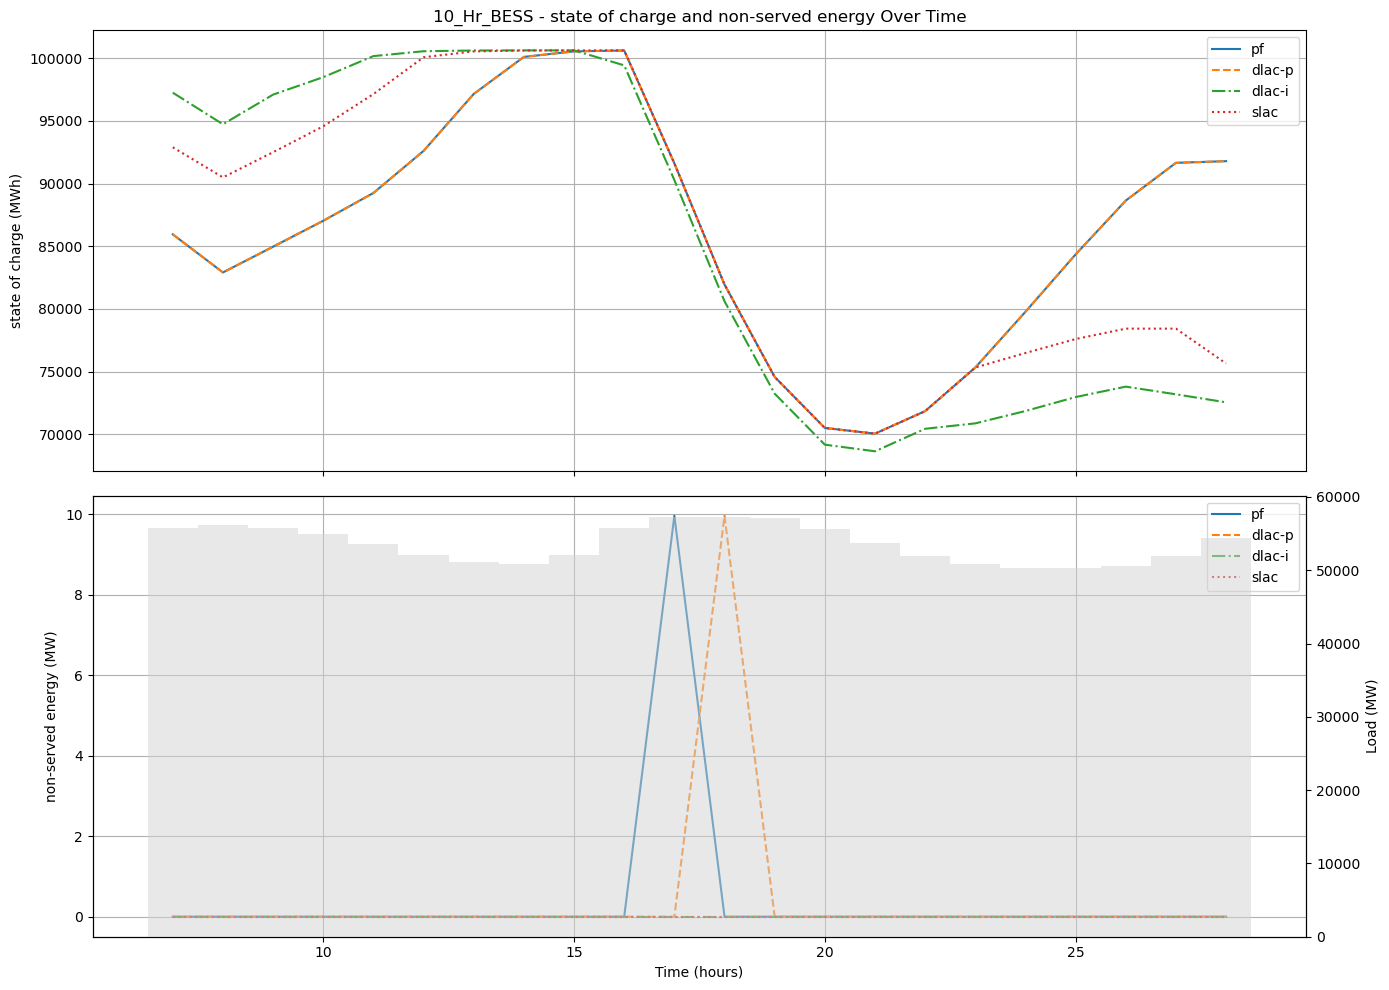

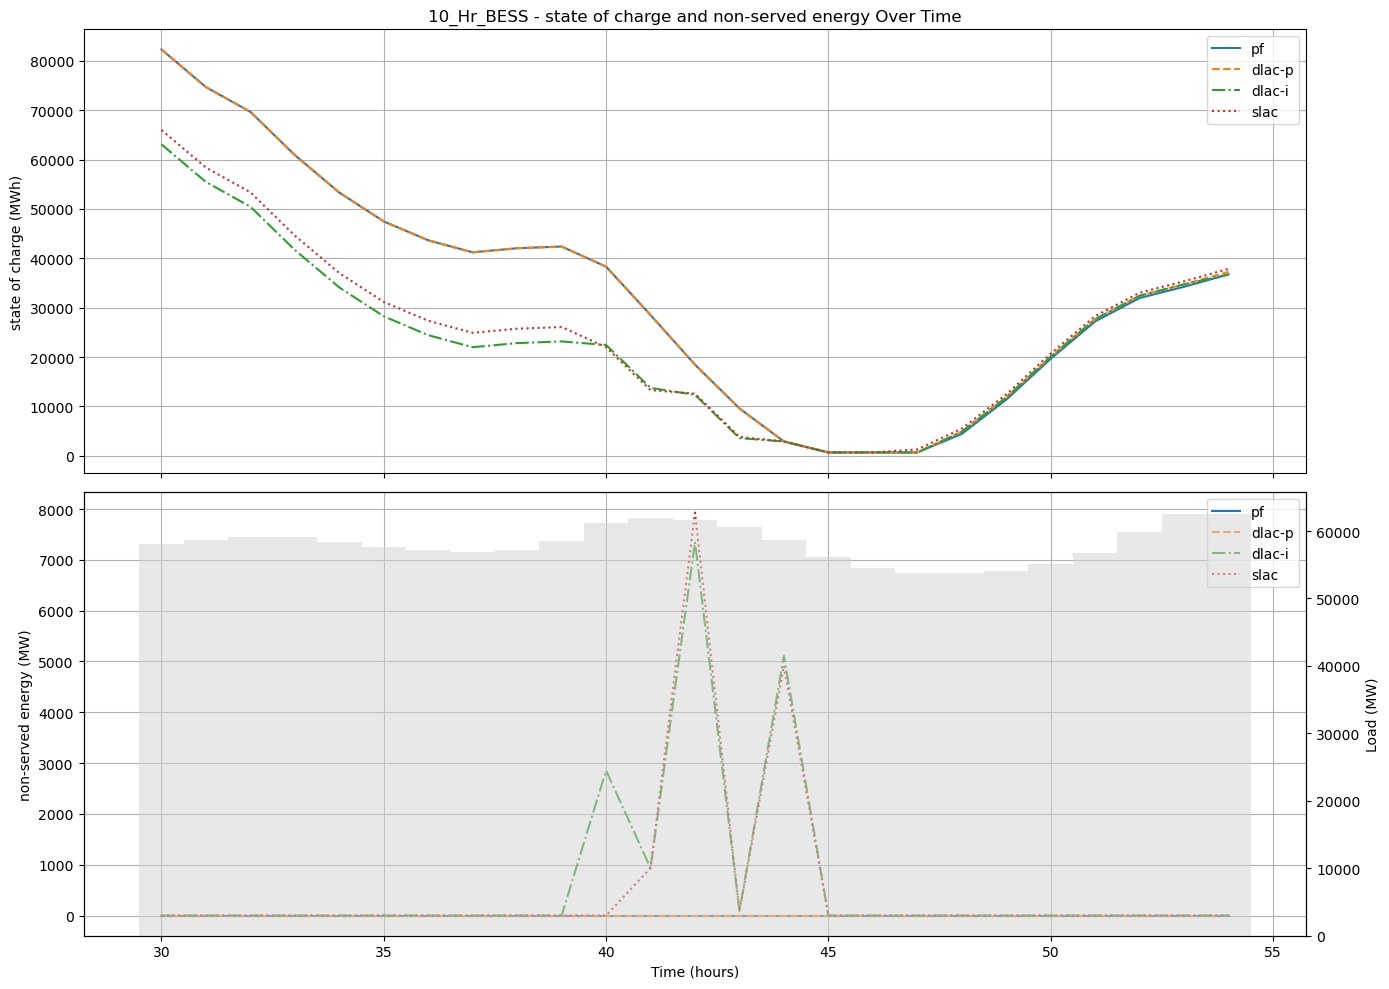

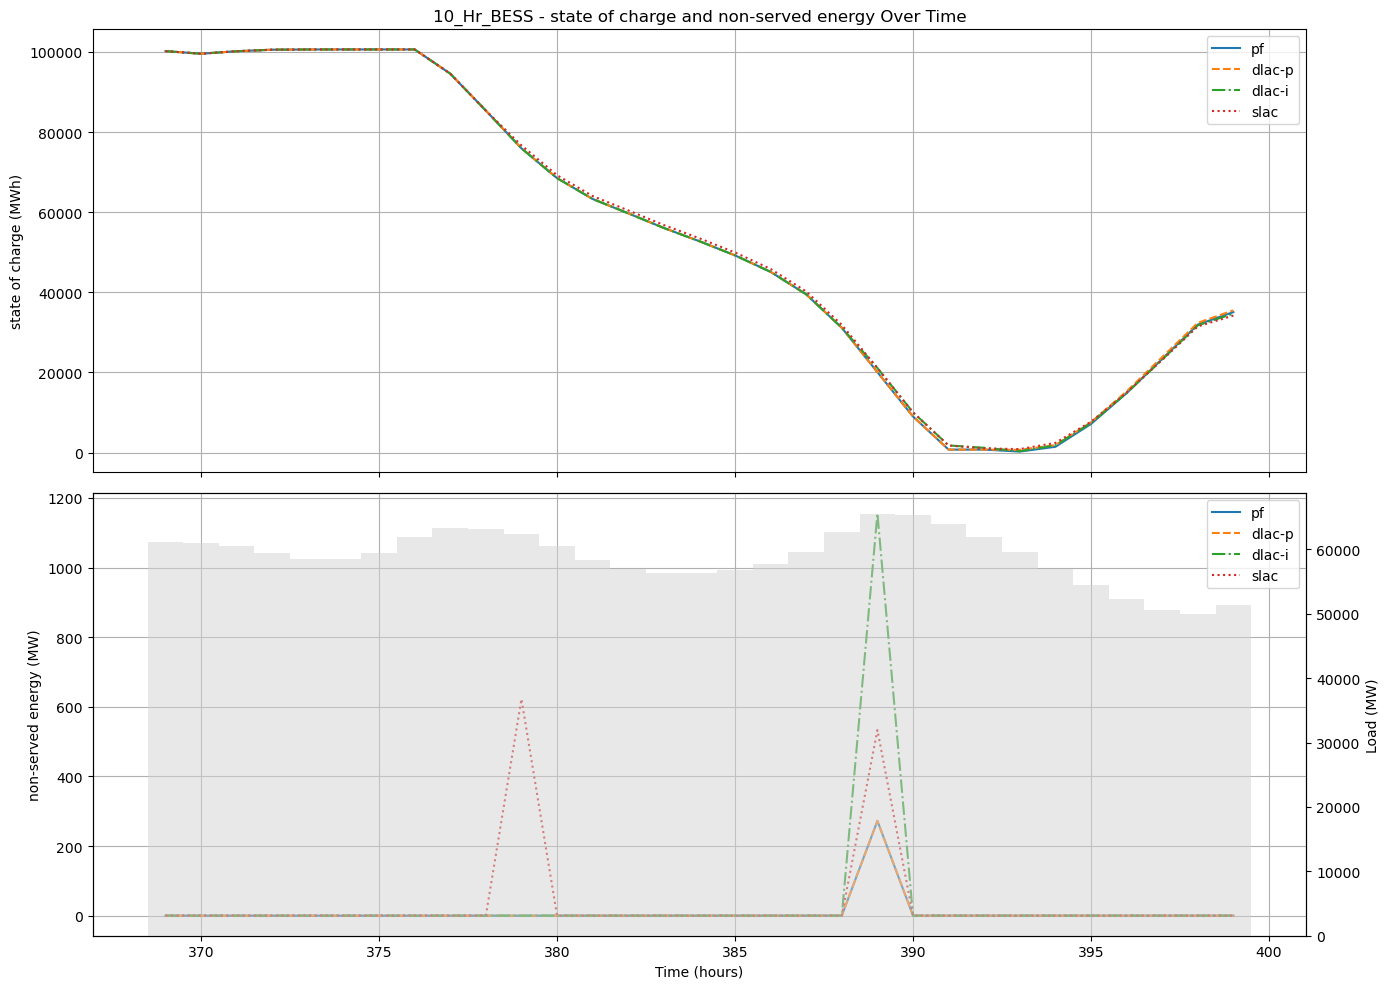

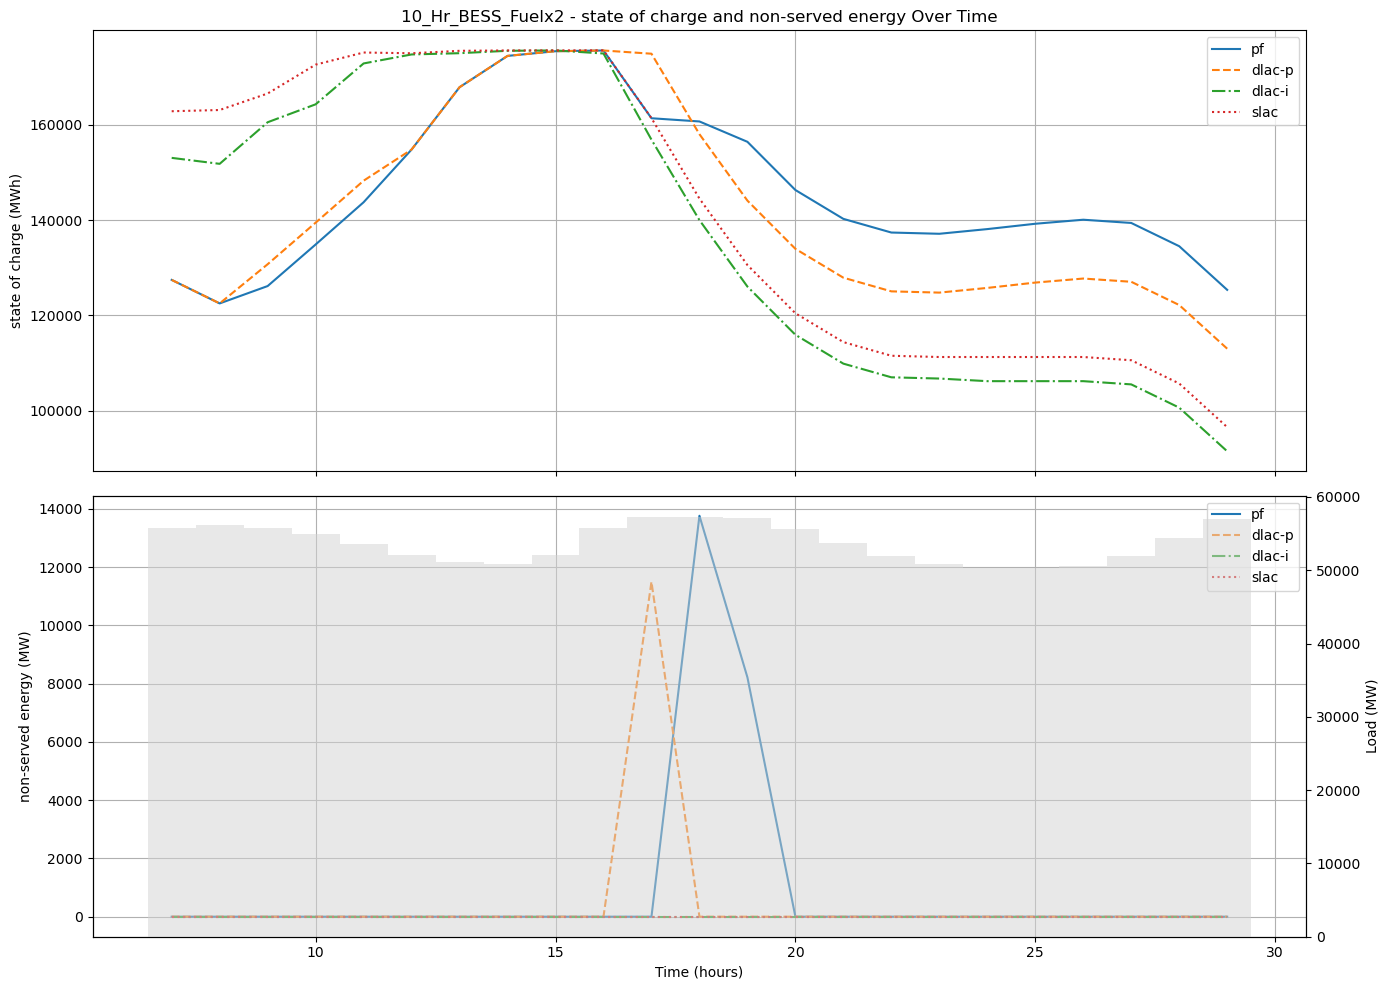

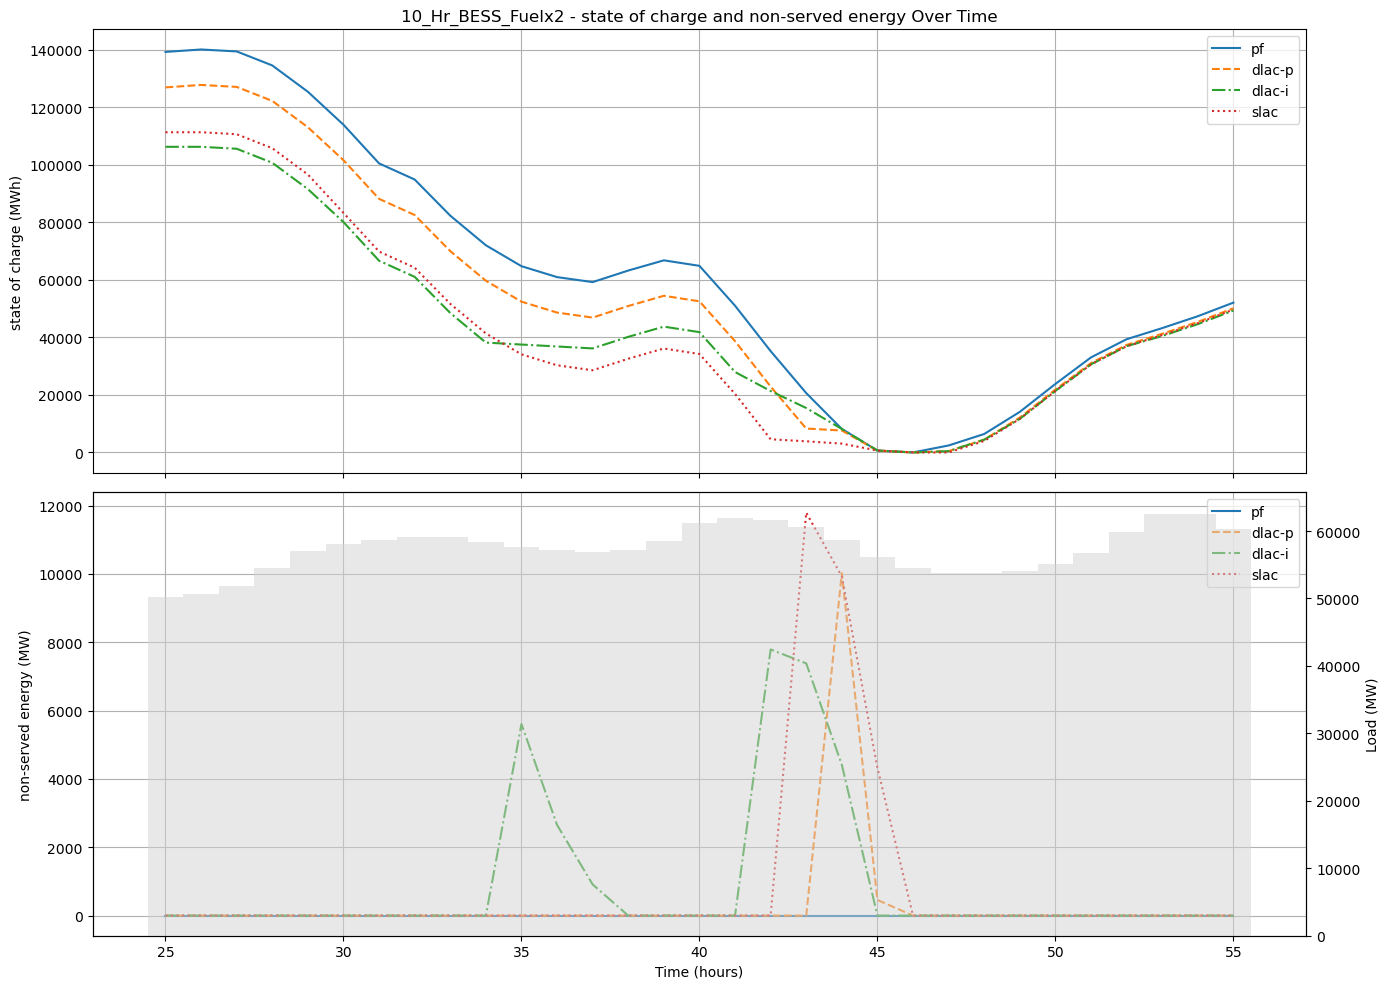

In [338]:
for case_name in case_names_sans_thermal:
    top_cem_data, top_policies_data_dict, top_columns_2_print = \
                    get_case_outputs_all_models(cem_path, policies_path, 
                            case_name, top_variable_name, policy_types)
    btm_cem_data, btm_policies_data_dict, btm_columns_2_print = \
                    get_case_outputs_all_models(cem_path, policies_path, 
                            case_name, bottom_variable_name, policy_types)
    
    
    all_threshold_indices, btm_threshold_clusters, buffered_clusters = get_threshold_indices_and_clusters(
        btm_policies_data_dict, 
        policy_types, 
        btm_columns_2_print[0], 
        bottom_var_threshold, 
        max_gap=10, 
        buffer=10    
    )

    for i, indices in enumerate(buffered_clusters):
        if len(indices) == 0:
            continue
        
        # Plot top and bottom variables for all models
        plot_top_bottom_timeseries_all_models(
            corr_var_plot_path, case_name,
            load_data,
            top_cem_data, btm_cem_data, 
            top_policies_data_dict, btm_policies_data_dict, 
            policy_types, 
            top_columns_2_print, btm_columns_2_print,
            top_label=top_variable_name, 
            bottom_label=bottom_variable_name, 
            indices=indices, figsize=(14, 10)
        )   